### Environment setup

This project uses a reproducible Conda environment stored in  
`tipping_environment.yml`.

Create and activate it with:

```bash
conda env create -f tipping_environment.yml -n tipping-bounds
conda activate tipping-bounds


## Import Relevant Libraries

In [1]:
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
import ipywidgets as widgets

from IPython.core.magic import register_cell_magic
from pathlib import Path
from sklearn.preprocessing import RobustScaler

sns.set()

In [2]:
# ------------------------------------------------------------------------------
# Custom Jupyter cell magic: %%run_once
#
# Purpose:
#     Ensures that a cell is executed only ONE time, even if the user
#     reruns the whole notebook or accidentally re-executes a cell.
#
# Why this is useful:
#     - Prevents expensive data loading or merges from running multiple times
#     - Avoids redefining variables or overwriting files repeatedly
#     - Helps when developing reproducible notebooks for GitHub
#
# Usage:
#     Put `%%run_once` at the TOP of any cell:
#
#         %%run_once
#         <code that should only run once>
#
# Behavior:
#     - On first execution → cell runs normally
#     - On later executions → prints "This cell has already been executed."
#
# Important:
#     This cell must be run BEFORE any use of %%run_once in the notebook.
# ------------------------------------------------------------------------------

from IPython.core.magic import register_cell_magic

executed_cells = set()

@register_cell_magic
def run_once(line, cell):
    cell_id = hash(cell)
    if cell_id in executed_cells:
        print("This cell has already been executed.")
    else:
        exec(cell, globals())
        executed_cells.add(cell_id)


In [4]:
# -------------------------------------------------
# Path to repo root (robust, works anywhere)
# -------------------------------------------------
REPO_ROOT = Path().resolve().parent.parent  # if notebook is in /notebooks/
# OR use this if notebook is in repo root:
# REPO_ROOT = Path().resolve()

# -------------------------------------------------
# Directory aliases matching original codebase
# -------------------------------------------------
dir_outcomes_and_controls = REPO_ROOT  # currently CSVs live in repo root
dir_signals               = REPO_ROOT  # update later if you add a signals folder


In [5]:
# Load main outcomes/controls dataset
outcomes_and_controls_df = pd.read_csv(dir_outcomes_and_controls + "controls_and_outcomes.csv")

# Load sector-level variables (subset of columns)
sector_df = pd.read_csv(
    dir_outcomes_and_controls + "sector_variables.csv",
    usecols=['Date','factset_entity_id','name','GICS SECTOR','RoE_winsorized','forwardEPS_winsorized','returns_winsorized','mcap']
)

# Load Tobin's Q data
tobinsq_df = pd.read_csv(dir_outcomes_and_controls + "tobinsq.csv")

In [6]:
# Convert a 'YYYYQ' or 'YYYY<quarter>' string into a proper date.
# Maps quarter → first month of that quarter:
#   Q1 → 01 (Jan), Q2 → 04 (Apr), Q3 → 07 (Jul), Q4 → 10 (Oct)
# Returns a canonical YYYY-MM-01 string for merging and time alignment.
def transform_date(date):
    year = date[:4]
    quarter = date[4]
    month = {
        '1': '01',
        '2': '04',
        '3': '07',
        '4': '10'
    }[quarter]
    return f'{year}-{month}-01'

# Apply transformation to quarterly identifiers
tobinsq_df['yearquart'] = tobinsq_df['yearquart'].astype(str).apply(transform_date)
outcomes_and_controls_df['yearquart'] = outcomes_and_controls_df['yearquart'].astype(str).apply(transform_date)


In [7]:
%%run_once
# Merge outcomes/controls with sector data and dividends:
# 1) First merge matches firm-quarter rows to sector characteristics
#    using (yearquart, factset_id) ↔ (Date, factset_entity_id).
# 2) Second merge adds quarterly dividend info from dividends_df
#    using (yearquart, factset_id) ↔ (yq, factset_id).
# 3) Finally, keep only the variables required downstream.
merged_df = pd.merge(outcomes_and_controls_df,
                     sector_df,
                     left_on=['yearquart', 'factset_id'],
                     right_on=['Date', 'factset_entity_id'],
                     how='left')

#merged_df = pd.merge(merged_df,
#                     dividends_df[['factset_id', 'yq', 'dividends']],
#                     left_on=['yearquart', 'factset_id'],
#                     right_on=['yq', 'factset_id'],
#                     how='left')

outcomes_and_controls_df = merged_df[
    [
        'factset_id', 'yearquart', 'name', 'GICS SECTOR',
        'tot_employees', 'assets_tot', 'lever',
        'p_women_senior_top_hq', 'p_gend_unknown_senior_top_hq',
        'p_ethni_unknown_snr_top_hq', 'p_nonwhite_senior_top_hq',
        'mcap'
    ]
]

In [8]:
%%run_once

# Ensure 'yearquart' in tobinsq_df and 'Date' in outcomes_and_controls_df are in the same format
# outcomes_and_controls_df['Date'] = outcomes_and_controls_df['Date'].astype(str)

outcomes_and_controls_df['yearquart'] = pd.to_datetime(outcomes_and_controls_df['yearquart'], format='%Y-%m-%d')
outcomes_and_controls_df['factset_id'] = outcomes_and_controls_df['factset_id'].astype(str)

# tobinsq_df['yearquart'] = tobinsq_df['yearquart'].astype(str)

tobinsq_df['yearquart'] = pd.to_datetime(tobinsq_df['yearquart'], format='%Y-%m-%d')
tobinsq_df['factset_id'] = tobinsq_df['factset_id'].astype(str)

merged_df = outcomes_and_controls_df.merge(tobinsq_df,
                                           left_on  = ['yearquart', 'factset_id'],
                                           right_on = ['yearquart', 'factset_id'],
                                           how = 'left')

# Assign the 'tobinsq' values back to the original DataFrame
outcomes_and_controls_df[['tobinsq','tobinsq_std']] = merged_df[['tobinsq','tobinsq_std']]
outcomes_and_controls_df = outcomes_and_controls_df.rename(columns={'yearquart': 'Date', 'factset_id': 'factset_entity_id'})


<string>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<string>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [9]:
# First, make sure your 'Date' column is datetime
outcomes_and_controls_df['Date'] = pd.to_datetime(outcomes_and_controls_df['Date'])

# Sort values within each group by Date
outcomes_and_controls_df.sort_values(by=['factset_entity_id', 'Date'], inplace=True)

In [10]:
# Scale Tobin's Q using RobustScaler (reduces sensitivity to outliers)
scaler = RobustScaler()
outcomes_and_controls_df["tobinsq_scaled"] = scaler.fit_transform(outcomes_and_controls_df[['tobinsq']])

In [11]:
%%run_once
# Build simple_signal_df (same as outcomes_and_controls_df for now)
simple_signal_df = outcomes_and_controls_df  # keep all cols

# Store dataset in a dictionary for later use
datasets = {
    "simple_signal": simple_signal_df,
}

In [12]:
%%run_once

entity_col = 'factset_entity_id'
time_col = 'date'

#column renaming and datetime format
outcomes_and_controls_df = outcomes_and_controls_df.rename(columns = {'Date': 'date','GICS SECTOR': 'gics_sector', 'name': 'company_name'})
outcomes_and_controls_df[time_col] = pd.to_datetime(outcomes_and_controls_df[time_col])
for dataset_name in datasets.keys():
    datasets[dataset_name] = datasets[dataset_name].rename(columns = {'factset_entity_id': 'factset_entity_id', 'Date': 'date'})
    datasets[dataset_name][time_col] = pd.to_datetime(datasets[dataset_name][time_col])


In [13]:
%%run_once
# Convert percentage columns (those starting with 'p_' and not containing 'unknown')
# from 0–1 to 0–100 scale
for dataset_name in datasets.keys():
    ratio_signal_cols = [
        c for c in datasets[dataset_name].columns
        if c.startswith('p_') and "unknown" not in c
    ]
    datasets[dataset_name][ratio_signal_cols] = (
        datasets[dataset_name][ratio_signal_cols] * 100
    )

In [14]:
%%run_once
# Create threshold indicators and interactions for all ratio columns:
# - indicator_{k}_{col}: 1 if col > k
# - X_{k}_{col}:        interaction with the value (above threshold)
# - Xc_{k}_{col}:       interaction with the value (below threshold)
for dataset_name in datasets.keys():
    
    new_columns = {}
    
    for k in np.arange(5, 100, 5):
        for col in ratio_signal_cols:
            indicator_col_name_ratio = f"indicator_{k}_{col}"
            indicator_interact_name_ratio = f"X_{k}_{col}"
            complement_interact_name_ratio = f"Xc_{k}_{col}"            
            
            new_columns[indicator_col_name_ratio] = datasets[dataset_name][col] > k
            new_columns[indicator_interact_name_ratio] = (datasets[dataset_name][col] > k) * datasets[dataset_name][col]
            new_columns[complement_interact_name_ratio] = (datasets[dataset_name][col] < k) * datasets[dataset_name][col]

    # Add all new indicator/interaction columns
    new_columns_df = pd.DataFrame(new_columns, index=datasets[dataset_name].index)
    datasets[dataset_name] = pd.concat([datasets[dataset_name], new_columns_df], axis=1)

    # Defragment the DataFrame
    datasets[dataset_name] = datasets[dataset_name].copy()

In [15]:
%%run_once
# Remove companies with average headcount below 250
for dataset_name in datasets.keys():
    print(dataset_name)
    
    df = datasets[dataset_name]
    
    # Compute average employees per company
    avg_employees = df.groupby("factset_entity_id")["tot_employees"].mean()
    
    # Filter out companies with average employees >= 250
    valid_ids = avg_employees[avg_employees >= 250].index
    
    # Keep only rows from companies meeting the threshold
    datasets[dataset_name] = df[df["factset_entity_id"].isin(valid_ids)]
    
    print(len(datasets[dataset_name]))


simple_signal
25228


In [16]:
# Columns with real percentage signals (p_*, excluding unknowns, interactions, and mcap)
ratio_signal_cols = [
    i for i in datasets["simple_signal"].columns
    if ("p_" in i) and ("indicator" not in i) and ("X" not in i)
    and ("mcap" not in i) and ("unknown" not in i)
]

# Columns where percentages are unknown (noise variables)
ratio_noise_cols  = [
    i for i in datasets["simple_signal"].columns
    if "unknown" in i
]

In [17]:
%%run_once
#temporary fix - drop duplicates (only two observation and only different value is in RandD)
for dataset_name in datasets.keys():
    datasets[dataset_name] = datasets[dataset_name].drop_duplicates(subset = [entity_col, time_col])
    print(len(datasets[dataset_name]))


25228


In [18]:
# Define sector super-groups for downstream analysis
sector_groups = {
    "Cyclicals": [
        'Consumer Discretionary', 'Materials', 'Industrials', 'Real Estate'
    ],
    "Defensives": [
        'Health Care', 'Consumer Staples', 'Utilities'
    ],
    "Growth & Innovation": [
        'Information Technology', 'Communication Services'
    ],
    "Financials": ['Financials'],
    "Energy": ['Energy']
}

# Build grouped datasets: full sample and pre-2019 subset
datasets_all = {}
datasets_all["simple_signal"] = datasets["simple_signal"]
datasets_all["filtered_years"] = datasets_all["simple_signal"][datasets_all["simple_signal"]["date"] < "2019-09-01"]

# Create sector-based groups using the defined super-groups
for group_name, sector_list in sector_groups.items():
    datasets_all[group_name] = datasets["simple_signal"][
        datasets["simple_signal"]["GICS SECTOR"].isin(sector_list)
    ]


In [19]:
# List all unique GICS sectors present in the simple_signal dataset
datasets_all["simple_signal"]["GICS SECTOR"].unique()

array(['Health Care', 'Information Technology', 'Financials',
       'Industrials', 'Materials', 'Energy', 'Utilities',
       'Consumer Staples', 'Real Estate', 'Consumer Discretionary',
       'Communication Services', nan], dtype=object)

## Descriptive Statistics

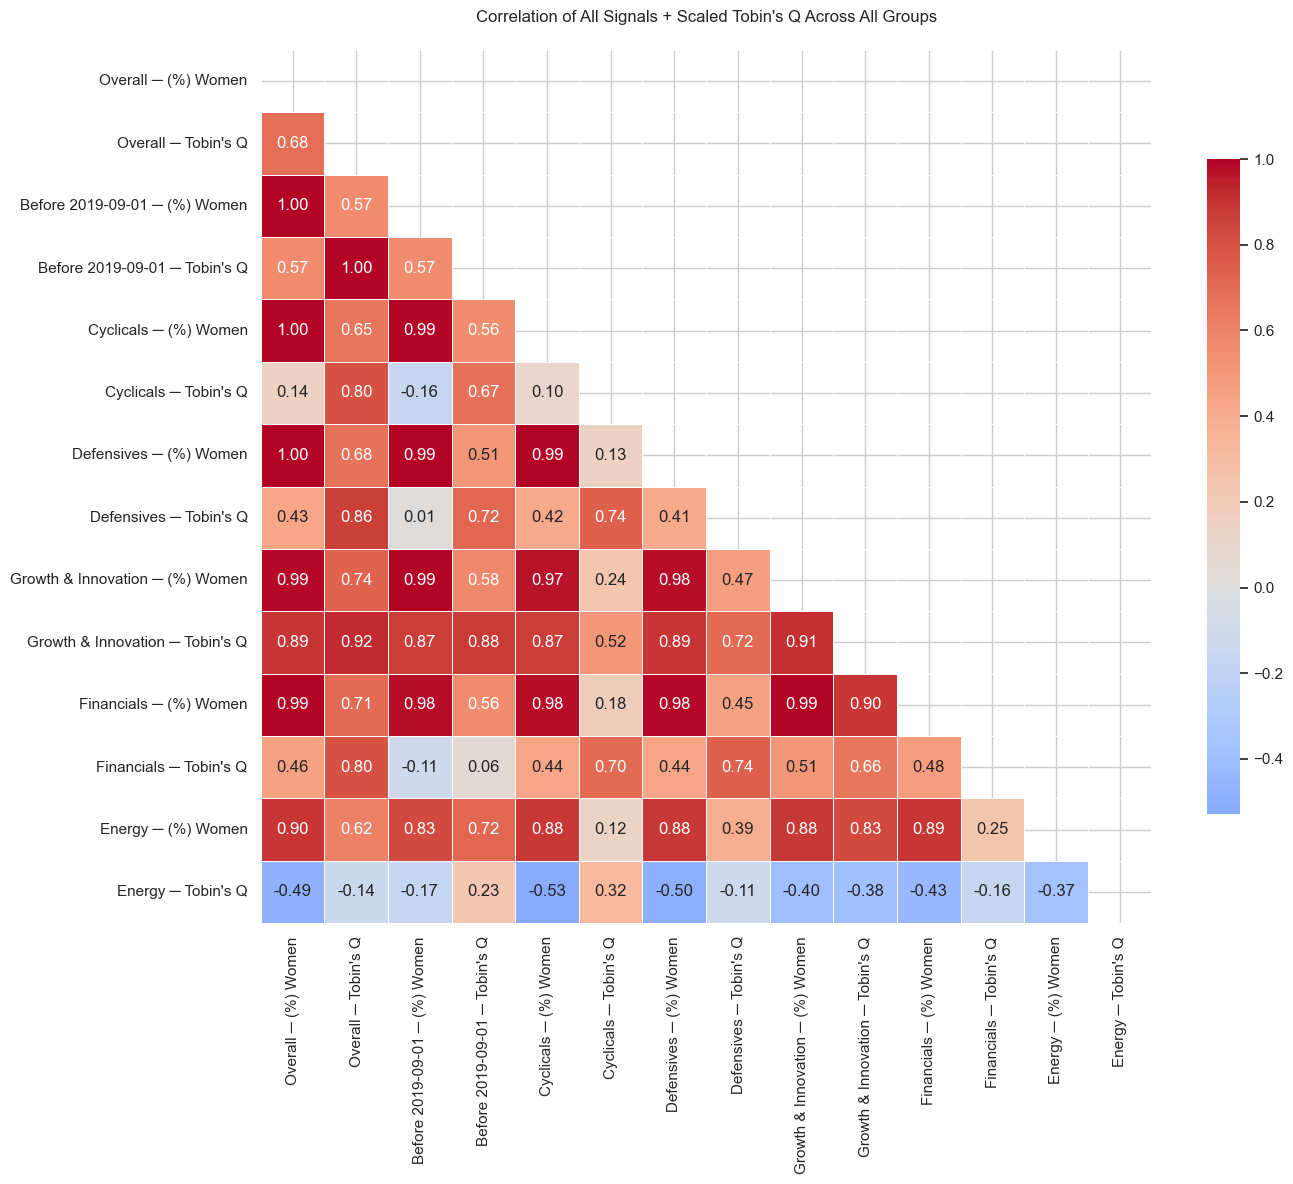

In [25]:
# -----------------------------------------------
# Correlation analysis across all dataset groups
# -----------------------------------------------

# Target variable for correlation
signal_corr = 'tobinsq_scaled'

# Ratio columns we want to study
ratio_signal_cols = [
    'p_women_senior_top_hq',
    'p_nonwhite_senior_top_hq'
]

# Nicer display names for the heatmap
rename_dict = {
    'tobinsq': 'Tobin\'s Q',
    'tobinsq_scaled': 'Tobin\'s Q',
    'tobinsq_std': 'Standardized Tobin\'s Q',
    'log_tobinsq': r'$\log(\mathrm{Tobin\'s\ Q})$',
    'p_women_senior_top_hq': '(%) Women',
    'p_nonwhite_senior_top_hq': '(%) Nonwhite'
}

# 1) Compute per-dataset daily averages (skip dividend splits)
df_list = []
for key, ds in datasets_all.items():
    if "dividend" not in key:
        small = (
            ds.groupby('date')[[ratio_signal_cols[0]] + [signal_corr]]
              .mean()
              .copy()
        )

        # Human-readable dataset label
        label = (
            key.title()
               .replace("_", " ")
               .replace("Simple Signal", "Overall")
               .replace("Filtered Years", "Before 2019-09-01")
        )

        # Prefix each column with its group name
        small.columns = [f"{label} ─ {col}" for col in small.columns]
        df_list.append(small)

# 2) Merge all group-level tables on 'date'
big = pd.concat(df_list, axis=1)

# 3) Full correlation matrix
corr_matrix = big.corr()

# 4) Rename columns using prettified suffixes
full_rename = {
    col: f"{col.split(' ─ ')[0]} ─ "
         f"{rename_dict.get(col.split(' ─ ')[1], col.split(' ─ ')[1])}"
    for col in corr_matrix.columns
}
corr_matrix.rename(index=full_rename, columns=full_rename, inplace=True)

# 5) Mask upper triangle for cleaner heatmap
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# 6) Plot heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(
    corr_matrix,
    annot=True,
    mask=mask,
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    fmt=".2f",
    cbar_kws={"shrink": .75}
)
plt.title("Correlation of All Signals + Scaled Tobin's Q Across All Groups", pad=20)
plt.xticks(rotation=90, ha="center")
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("CorrelationAnalysis_AllKeys.png", facecolor="white", bbox_inches="tight")
plt.show()


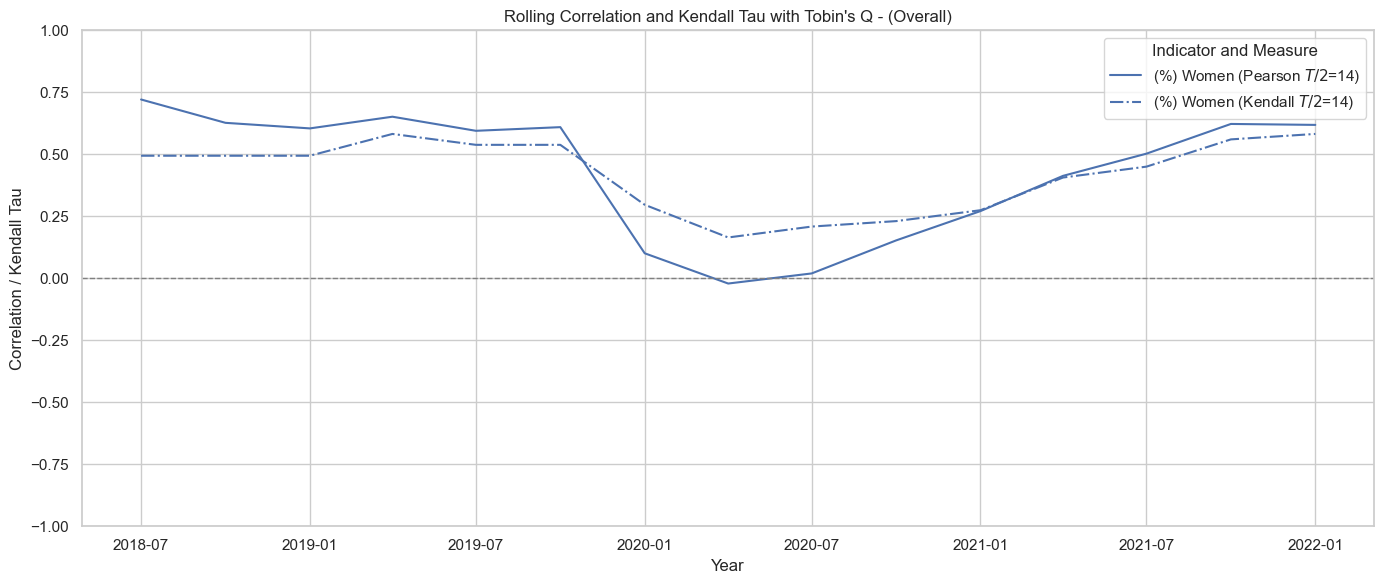

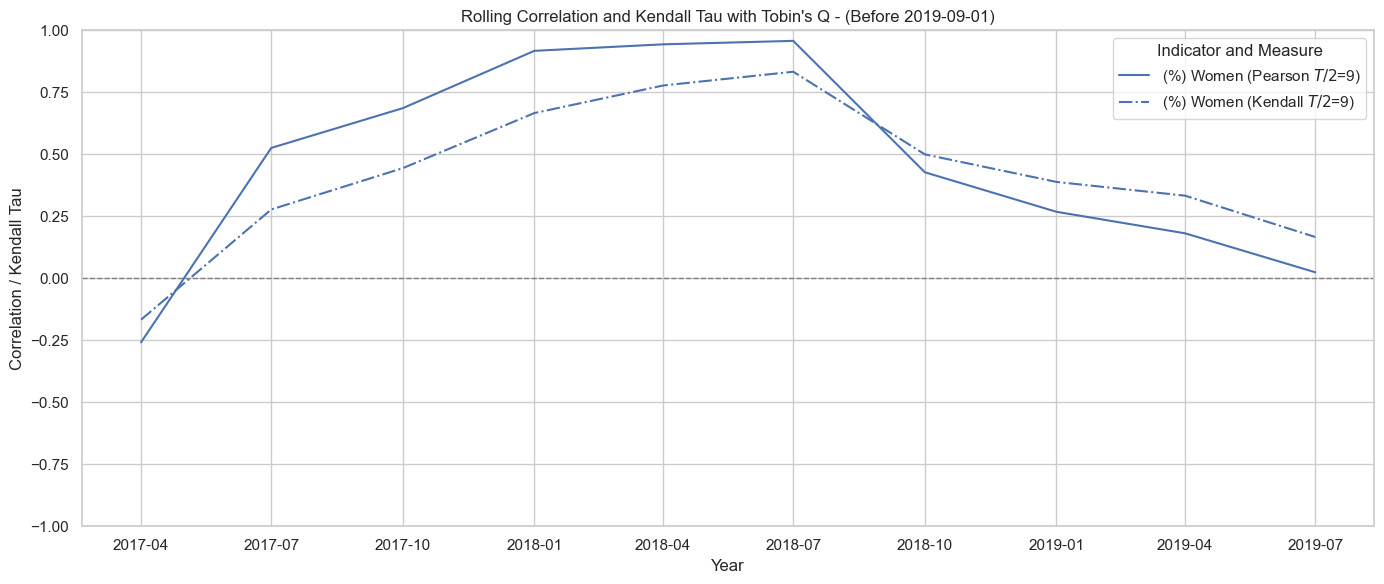

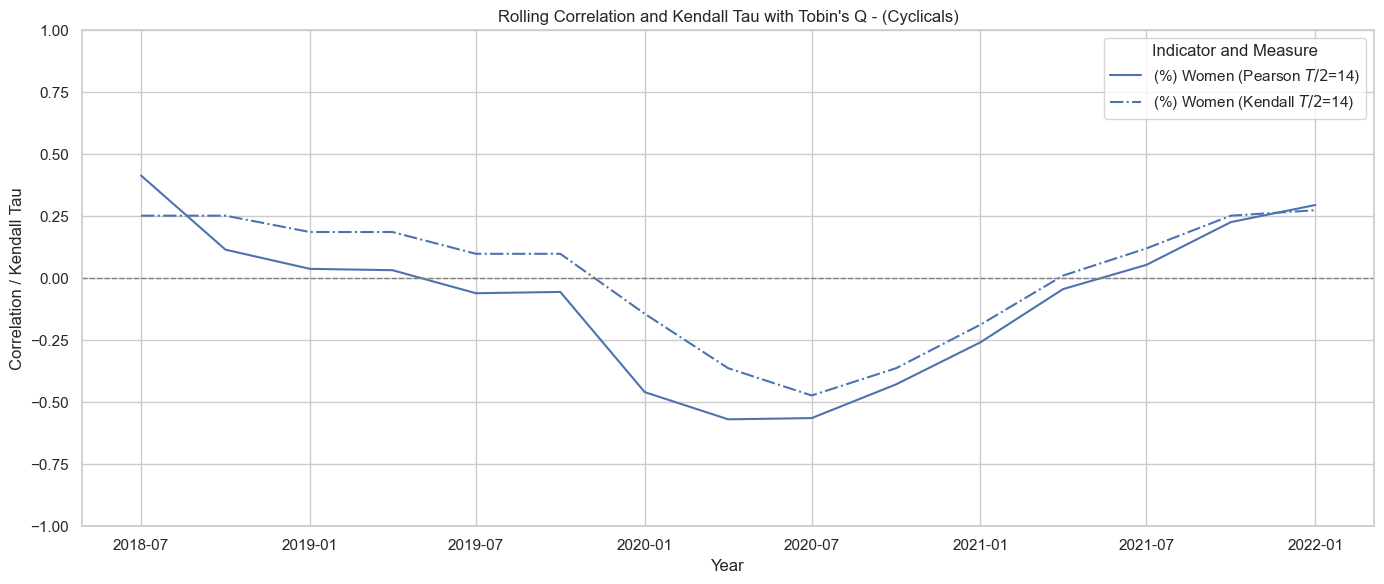

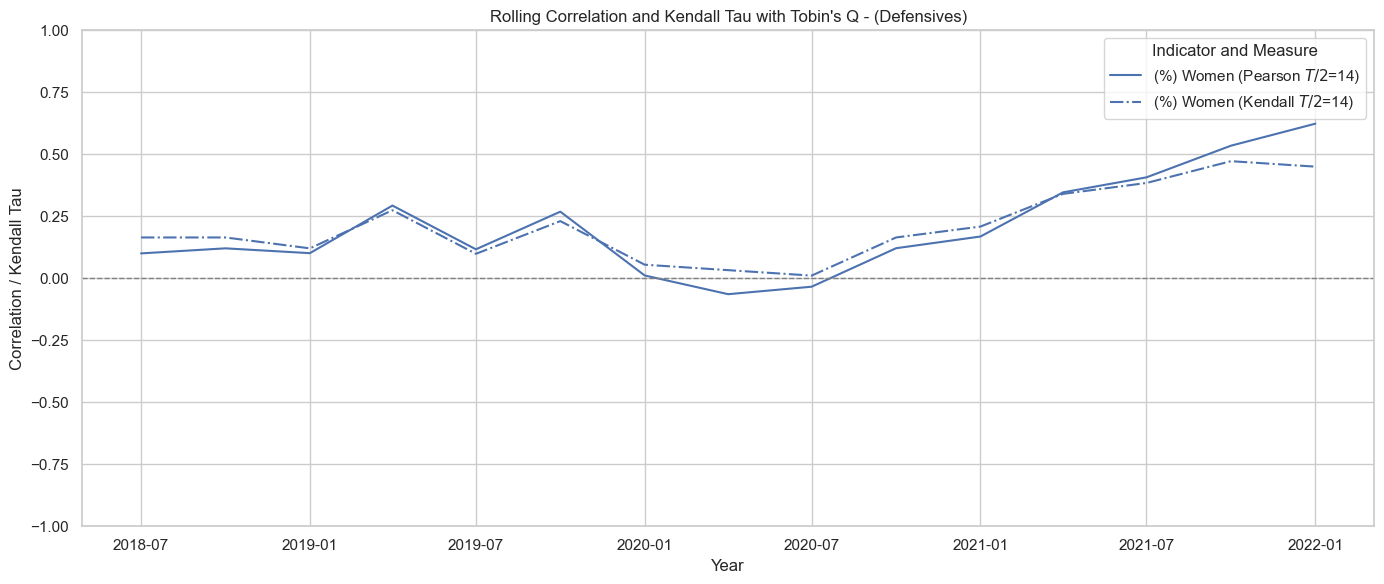

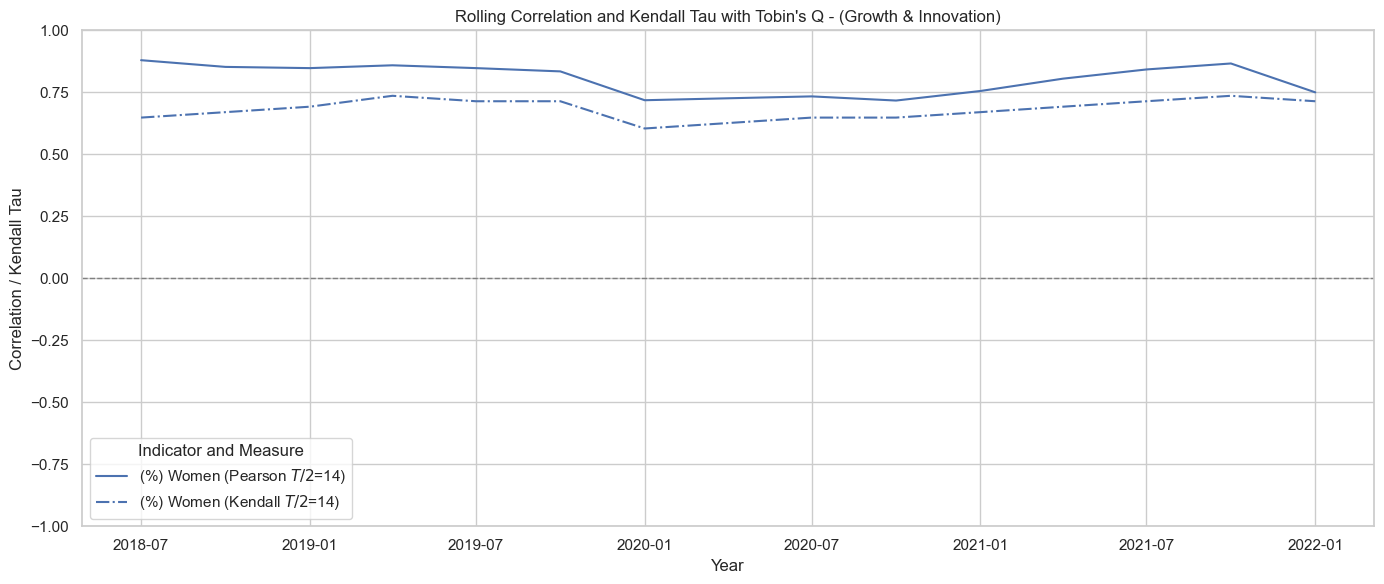

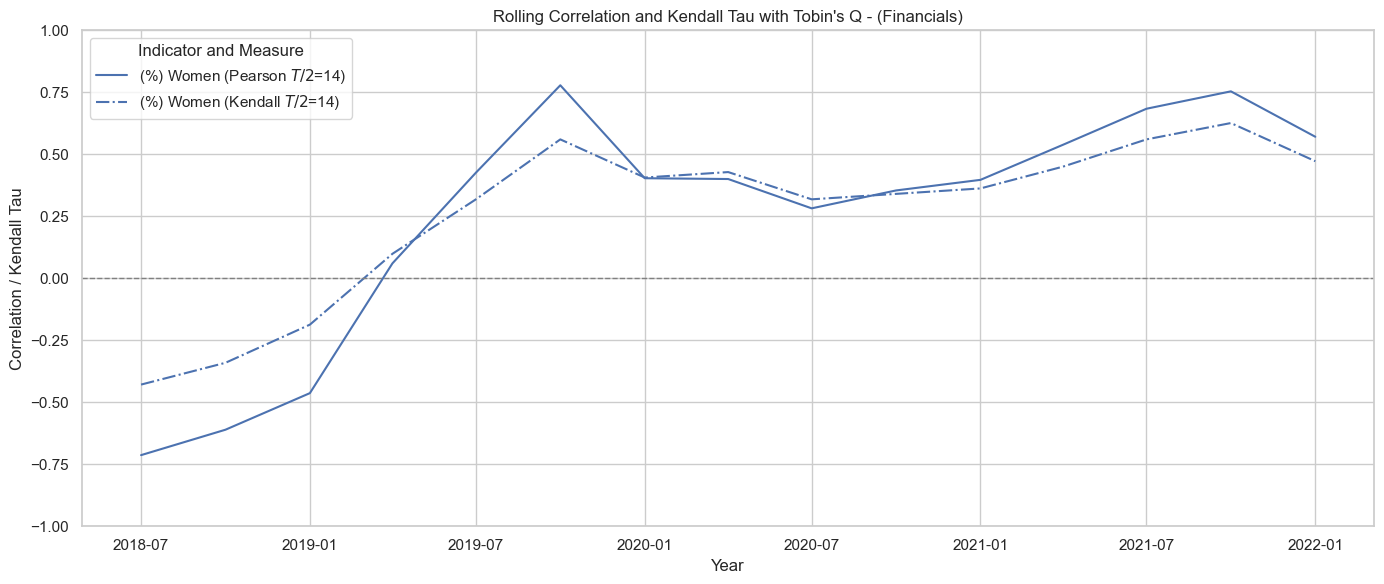

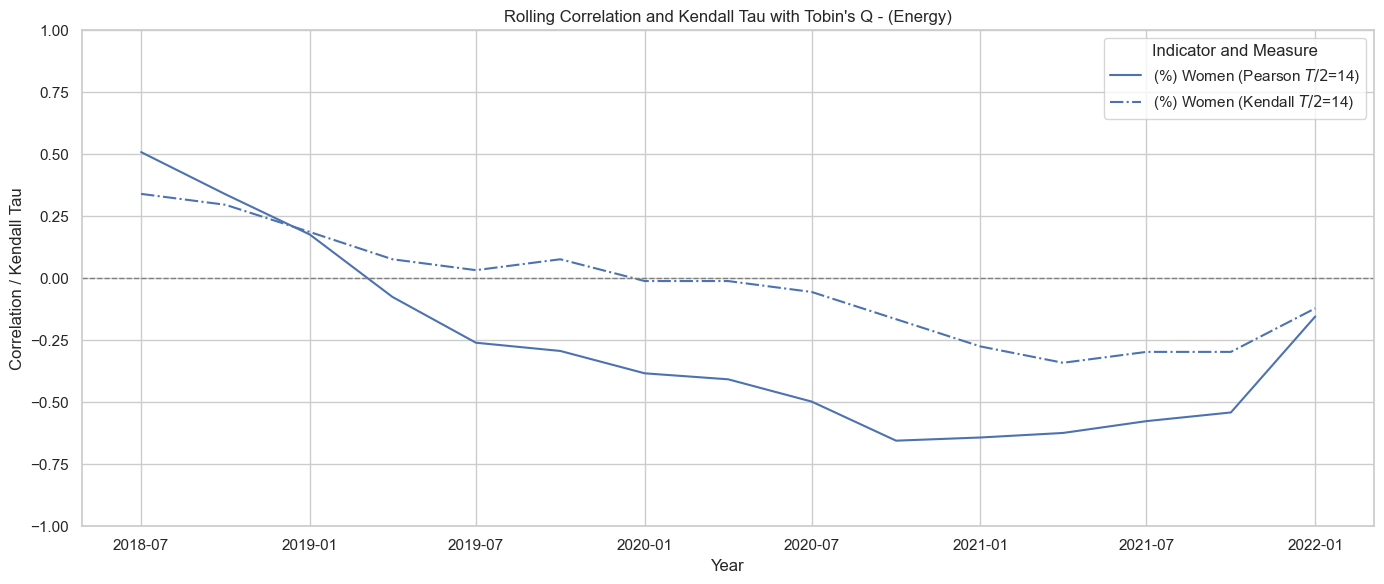

In [26]:
# -----------------------------------------------
# Rolling Pearson & Kendall correlation per group
# -----------------------------------------------
for key in datasets_all.keys(): 
    if "dividend" not in key:
        
        # Nice human-readable group name
        label_corr = (
            key.title()
               .replace("_"," ")
               .replace("Simple Signal","Overall")
               .replace("Filtered Years","Before 2019-09-01")
        )
        
        # Daily averages of the signal + Tobin's Q
        corr_df = (
            datasets_all[key]
            .groupby('date')[[ratio_signal_cols[0]] + [signal_corr]]
            .mean()
            .sort_index()  # chronological
        )
    
        # Rolling window: T/2
        n = len(corr_df)
        windows = {
            f'$T/2$={n//2}': n//2,
        }
    
        for window_label, window in windows.items():
            df_roll_corr = pd.DataFrame(index=corr_df.index)
            df_roll_tau = pd.DataFrame(index=corr_df.index)
    
            for col in [ratio_signal_cols[0]]:
                if col == signal_corr:
                    continue
    
                # Rolling Pearson
                df_roll_corr[col] = (
                    corr_df[signal_corr]
                    .rolling(window=window, min_periods=window)
                    .corr(corr_df[col])
                )
    
                # Rolling Kendall τ (manual loop to enforce full window)
                taus = [np.nan] * (window - 1)
                for i in range(window, len(corr_df) + 1):
                    sub_corr = corr_df[signal_corr].iloc[i - window:i]
                    sub_col = corr_df[col].iloc[i - window:i]
                    tau = sub_corr.corr(sub_col, method='kendall')
                    taus.append(tau)
                df_roll_tau[col] = taus
    
            # Pretty column names
            df_roll_corr.rename(columns=rename_dict, inplace=True)
            df_roll_tau.rename(columns=rename_dict, inplace=True)
    
            # Plot Pearson (solid) + Kendall τ (dash-dot)
            plt.figure(figsize=(14, 6))
            colors = {}
    
            for col in df_roll_corr.columns:
                line, = plt.plot(
                    df_roll_corr.index,
                    df_roll_corr[col],
                    label=f"{col} (Pearson {window_label})"
                )
                colors[col] = line.get_color()
                plt.plot(
                    df_roll_tau.index,
                    df_roll_tau[col],
                    linestyle='-.',
                    color=colors[col],
                    label=f"{col} (Kendall {window_label})"
                )
    
            plt.axhline(0, color='gray', linestyle='--', linewidth=1)
            plt.title(f"Rolling Correlation and Kendall Tau with Tobin's Q - ({label_corr})")
            plt.xlabel('Year')
            plt.ylabel('Correlation / Kendall Tau')
            plt.ylim(-1, 1)
            plt.legend(title='Indicator and Measure')
            plt.tight_layout()
    
            plt.savefig(f"RollingCorrelations_{key}.png", facecolor="white", bbox_inches="tight")
            plt.show()
            plt.close()


simple_signal


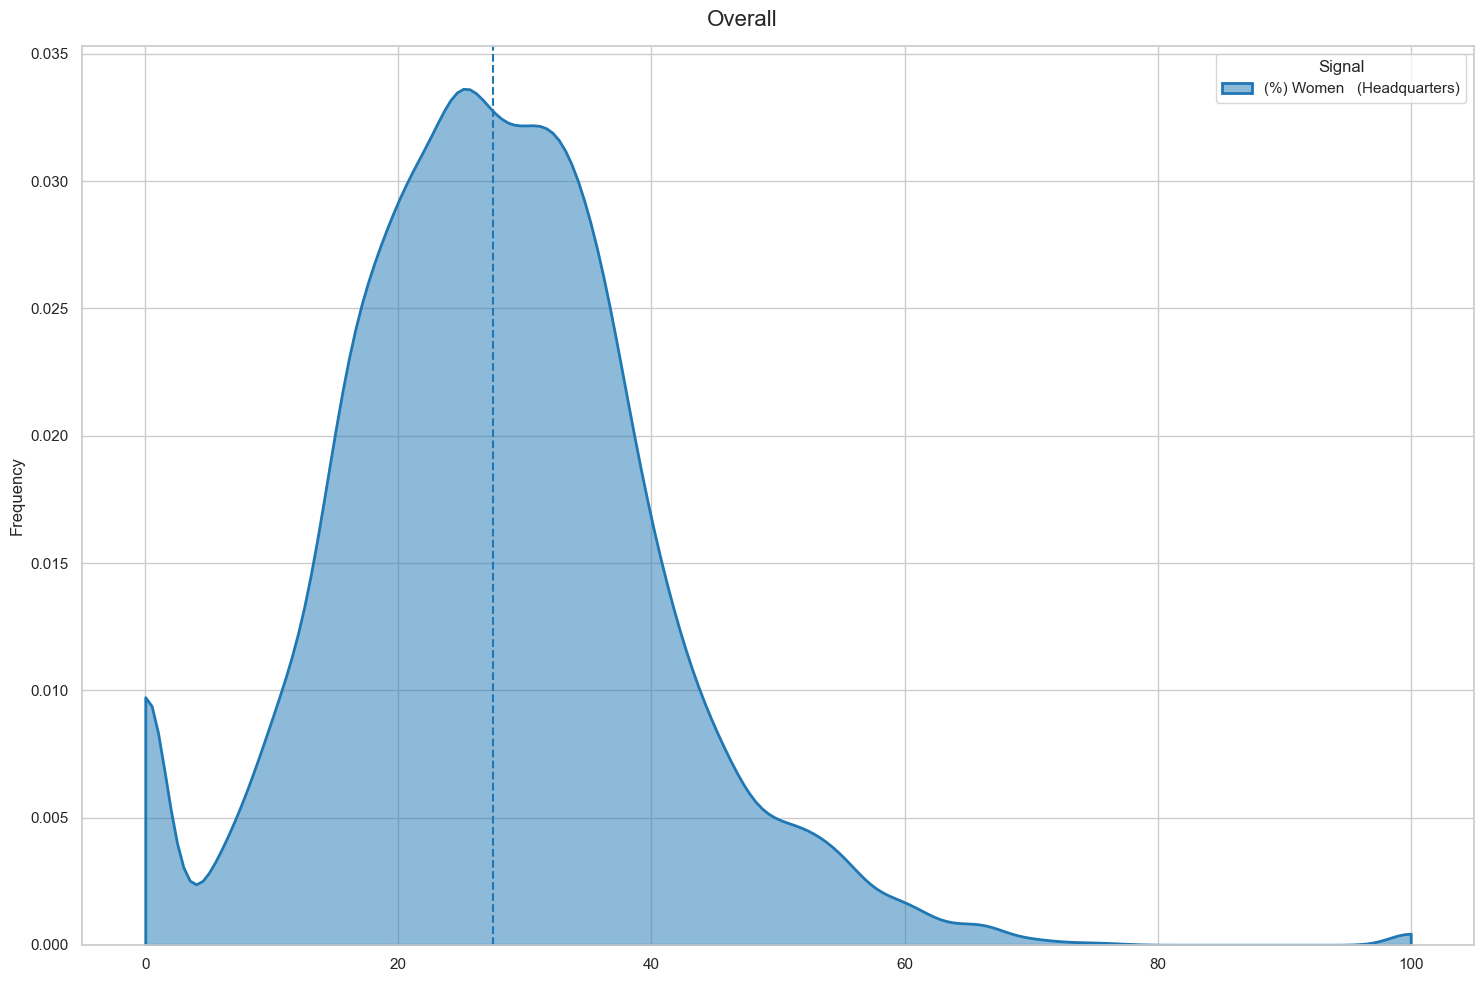

filtered_years


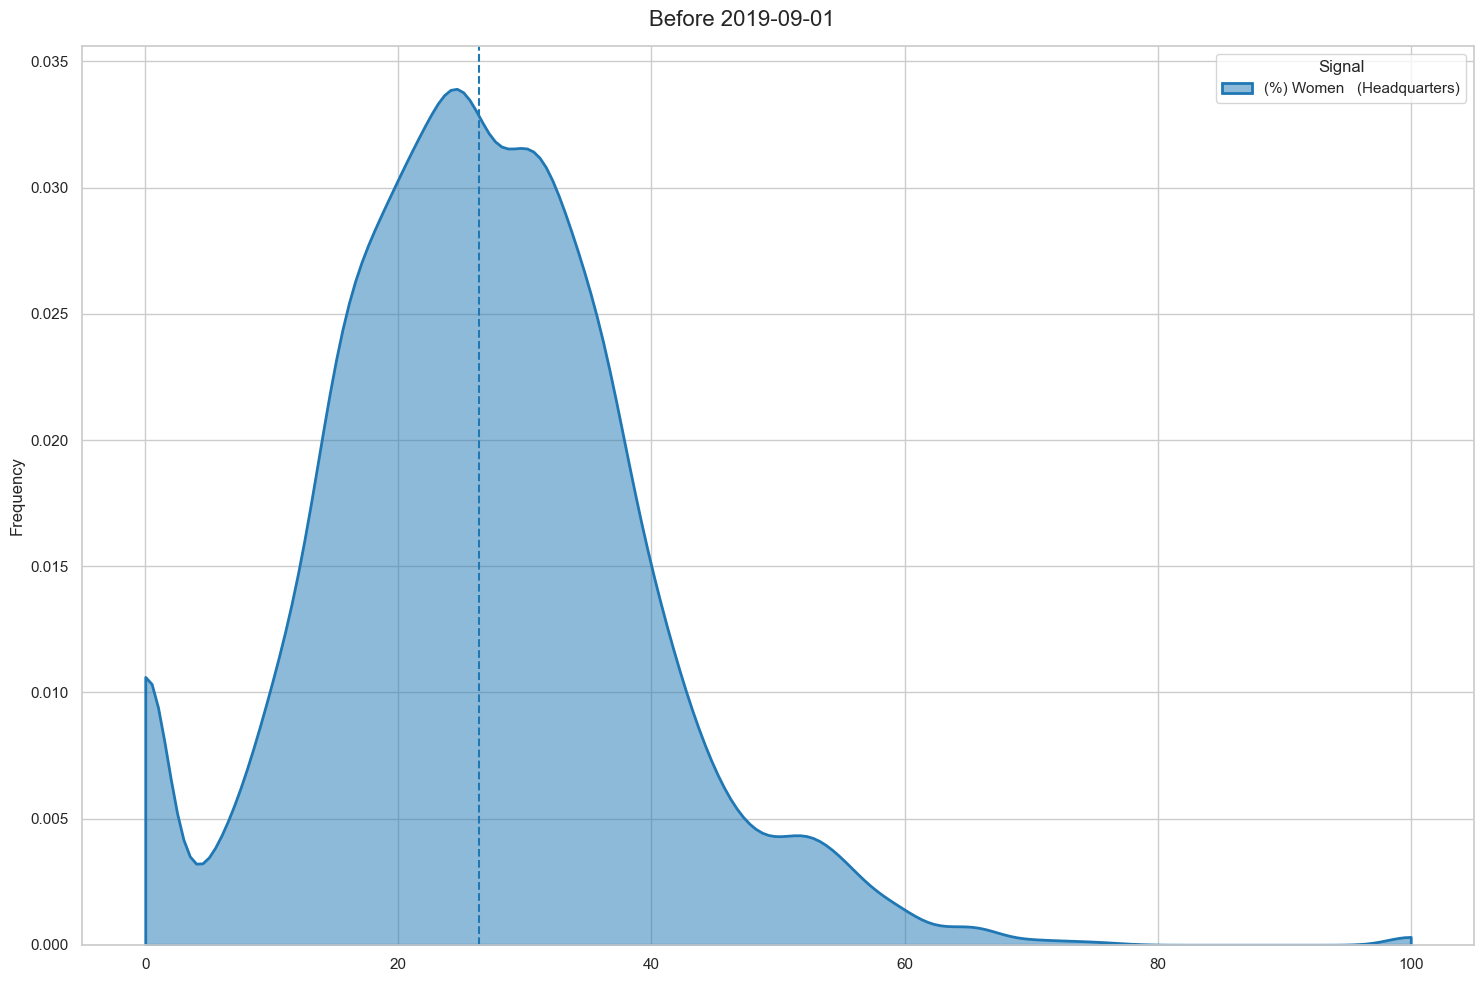

Cyclicals


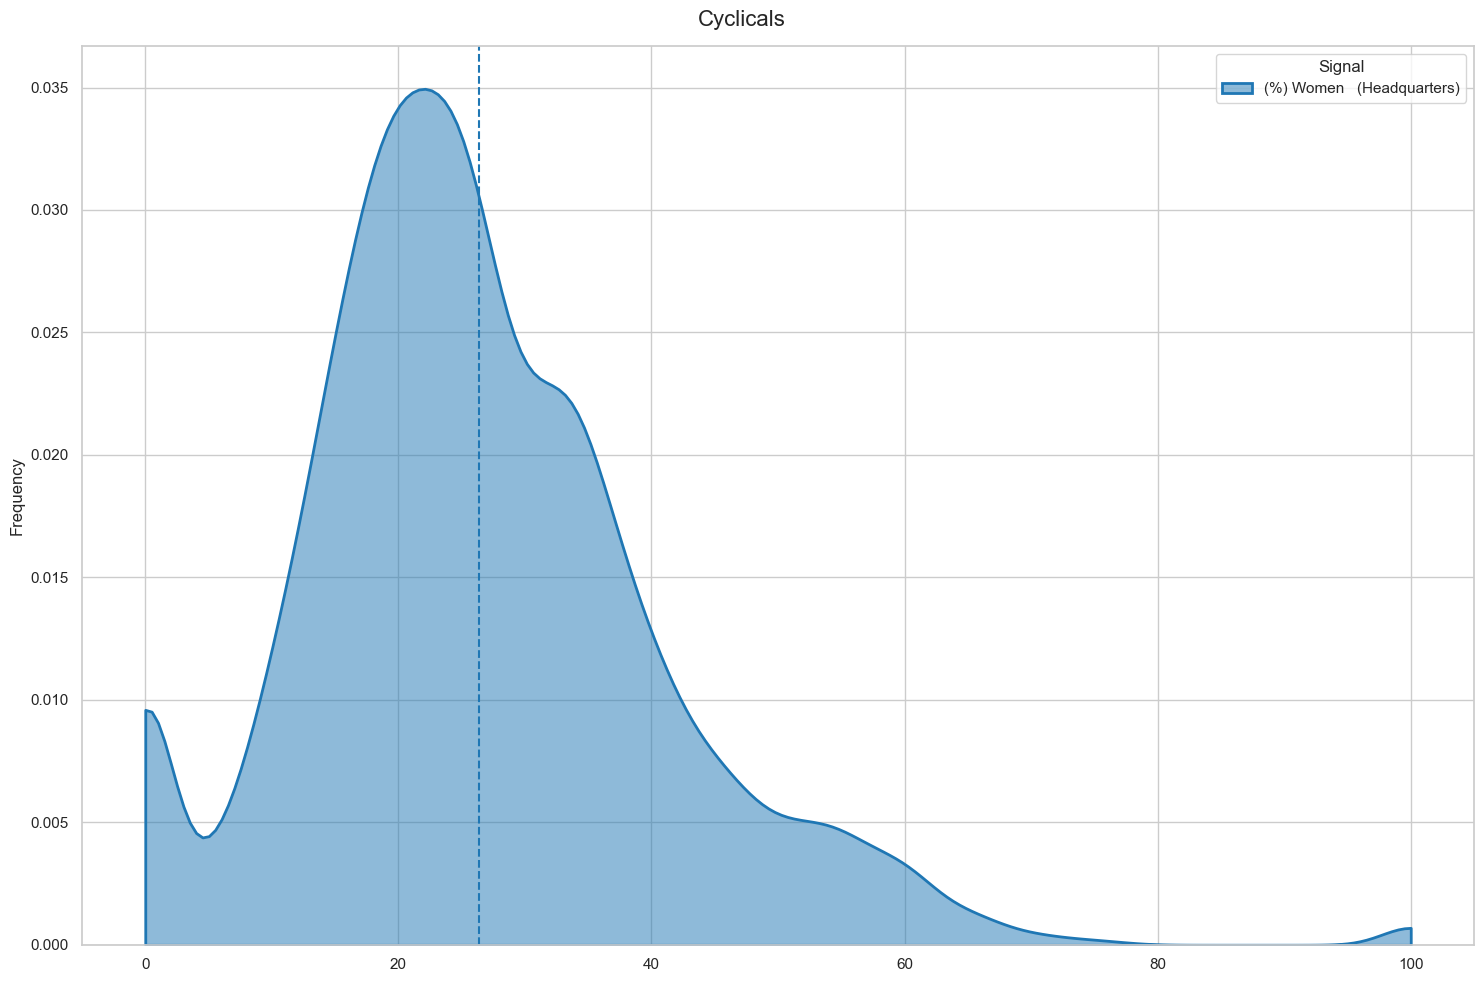

Defensives


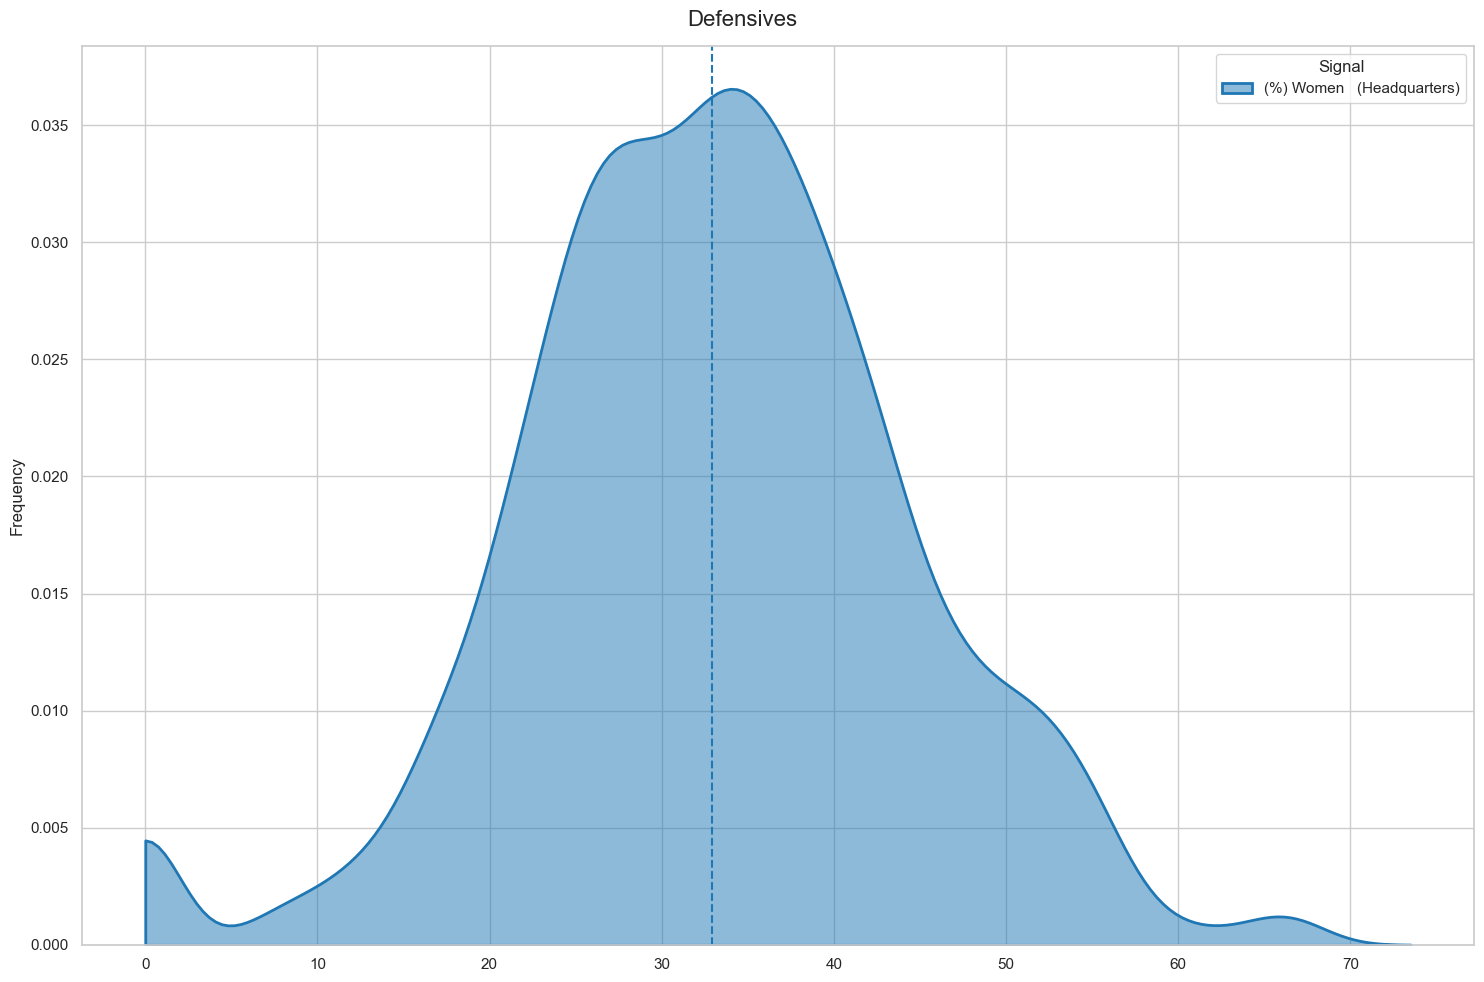

Growth & Innovation


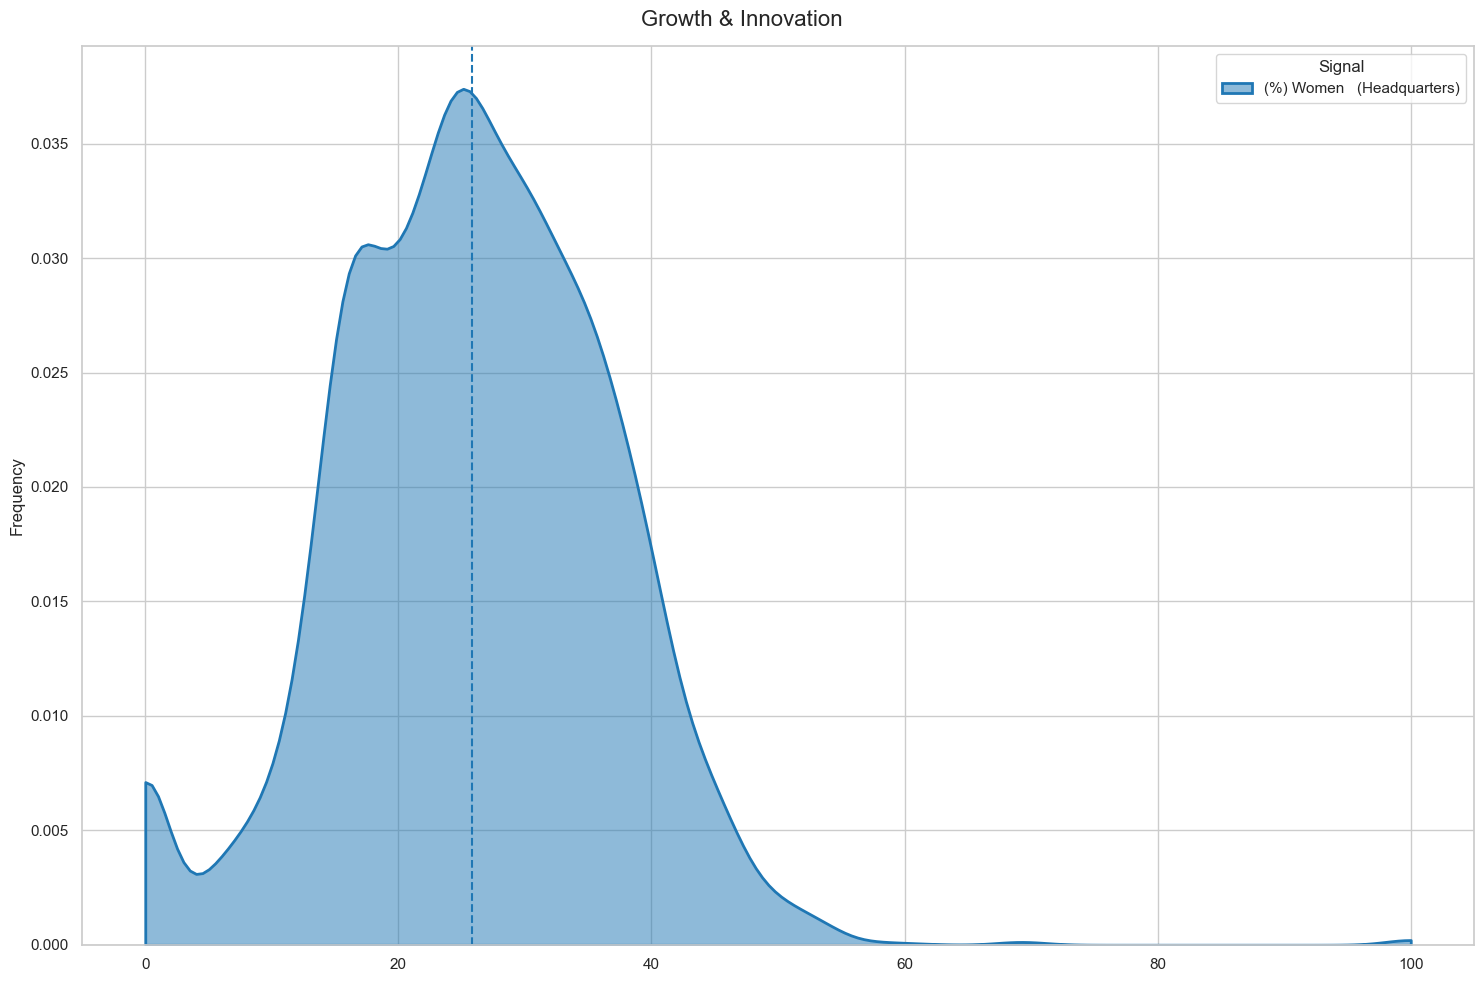

Financials


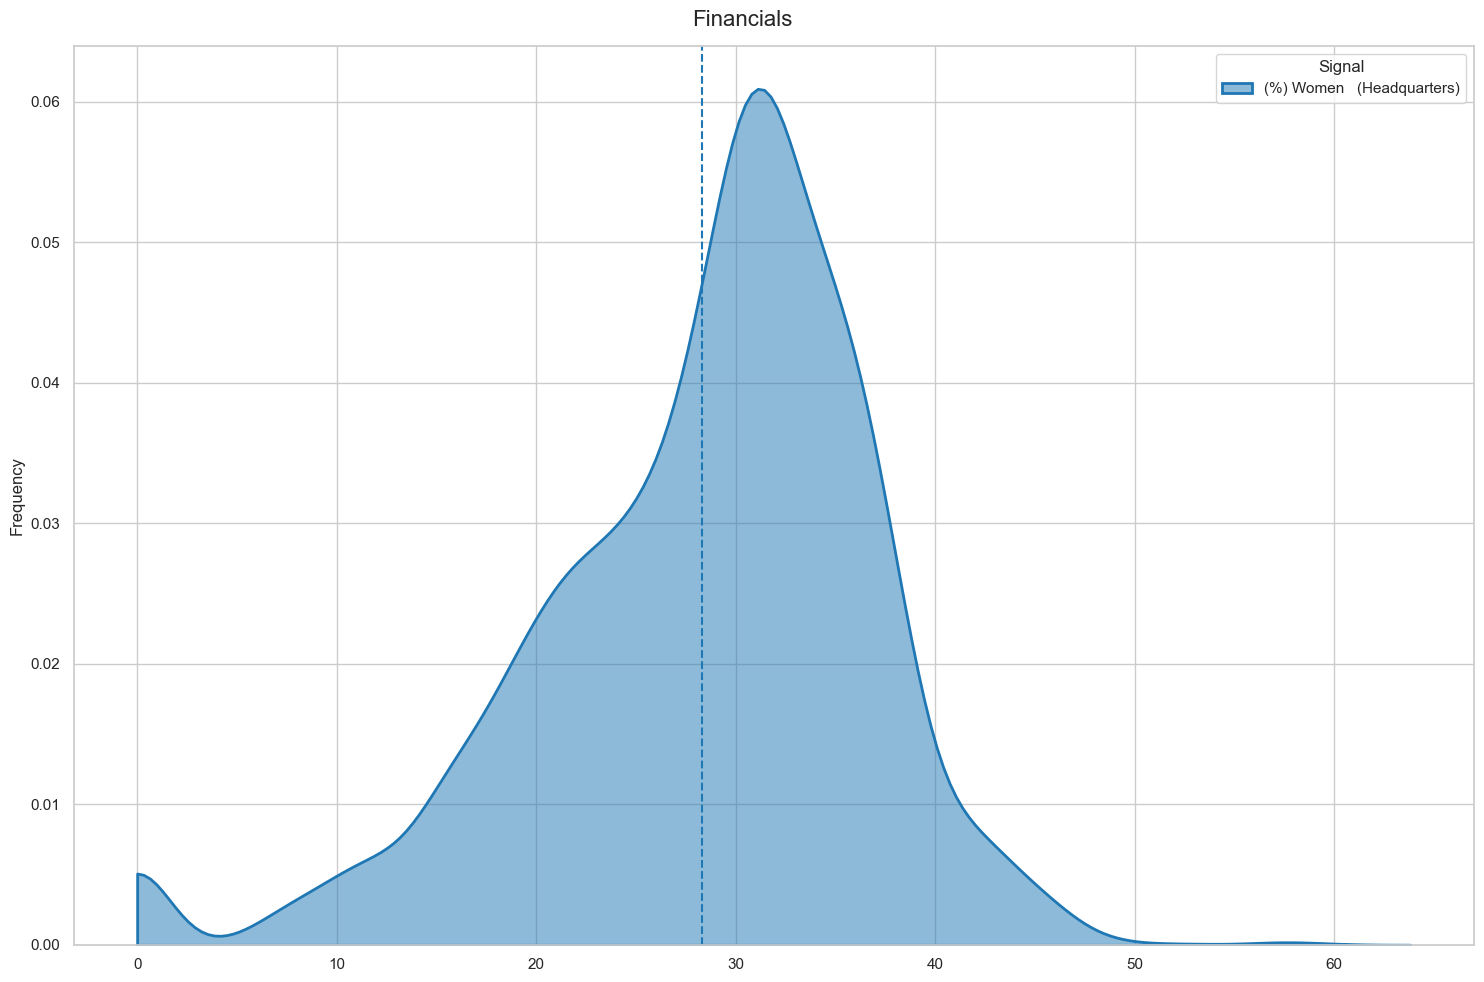

Energy


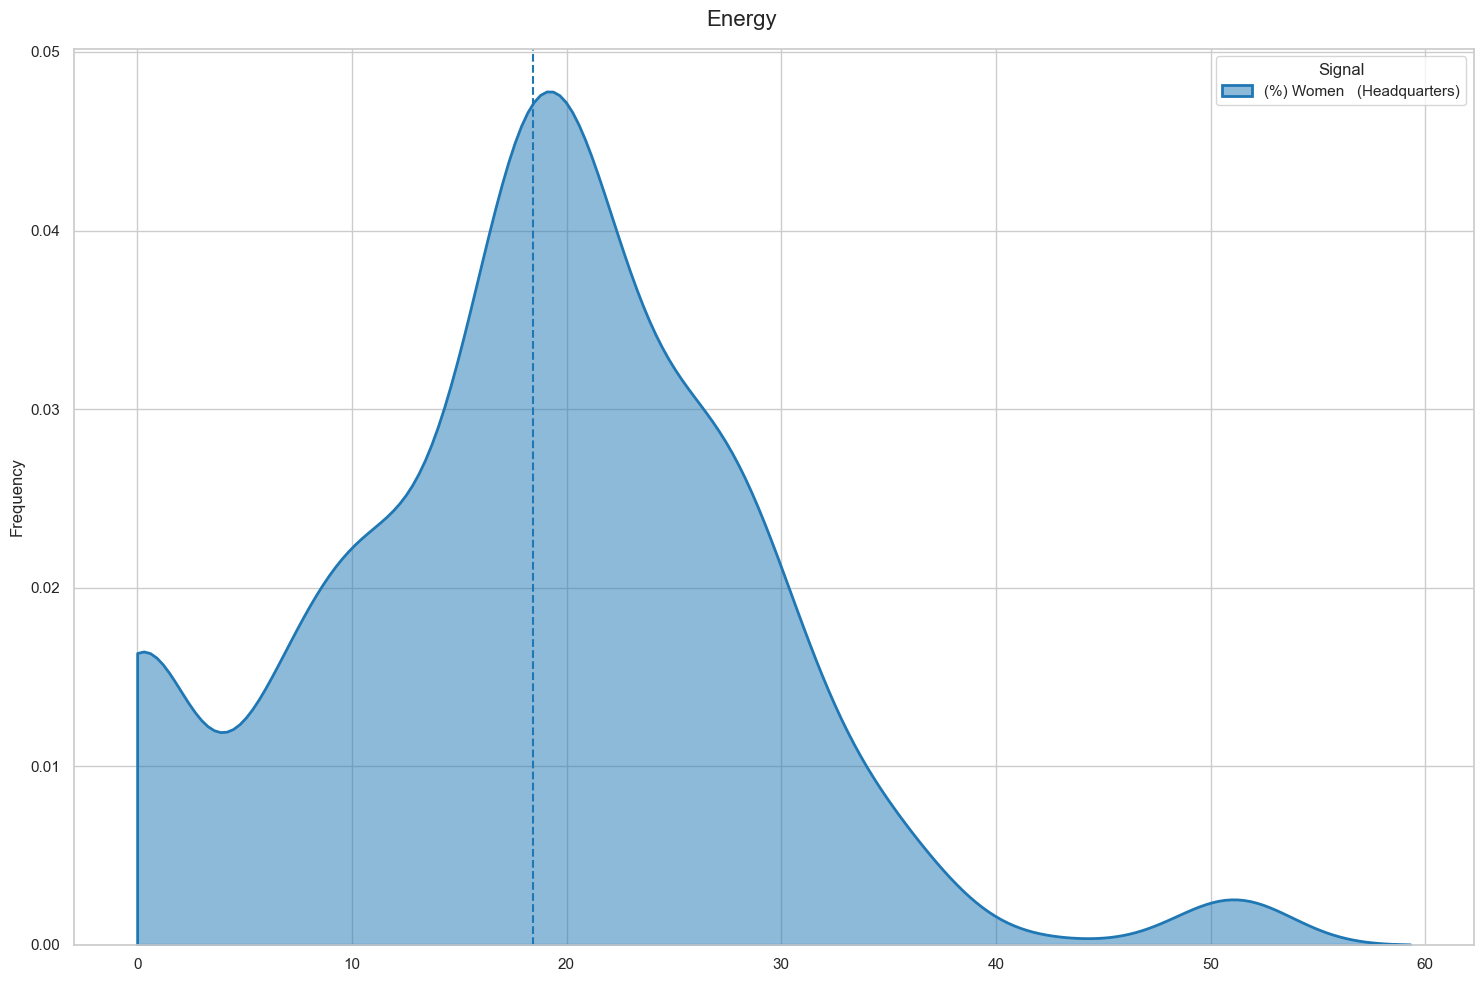

In [27]:
# KDE setup: clean whitegrid style + distinct colors
sns.set_style("whitegrid")
colors = sns.color_palette("tab10", n_colors=len([ratio_signal_cols[0]]))

for key in datasets_all.keys():
    if "dividend" not in key:
        print(key)
        
        # Figure per dataset group
        fig, ax = plt.subplots(figsize=(15, 10))
        
        # Human-friendly title
        label_key = (
            key.title()
               .replace("_", " ")
               .replace("Simple Signal", "Overall")
               .replace("Filtered Years", "Before 2019-09-01")
        )
        fig.suptitle(label_key, fontsize=16)
    
        # KDE for each signal column (here only ratio_signal_cols[0])
        for idx, col in enumerate([ratio_signal_cols[0]]):
            if "log" in col:
                continue
            
            data = datasets_all[key][col].dropna()
            
            # KDE density plot (smooth distribution)
            sns.kdeplot(
                data,
                ax=ax,
                bw_method='scott',
                fill=True,
                alpha=0.5,
                linewidth=2,
                color=colors[idx],
                clip=(0, 100),
                label=(
                    col.title()
                       .replace("P", "(%)")
                       .replace("_", " ")
                       .replace("Gend", "Gender")
                       .replace("Hq", "(Headquarters)")
                       .replace("Ethni", "Ethnicity")
                       .replace("  ", " ")
                       .replace("Snr", "")
                       .replace("Senior", "")
                       .replace("Top", "")
                )
            )
            
            # Mean indicator line
            ax.axvline(data.mean(), color=colors[idx], linestyle='--')
    
        # Clean axis labels but keep ticks
        ax.set_xlabel('')
        ax.set_ylabel('Frequency')
        ax.legend(title='Signal')
    
        plt.tight_layout()
        plt.savefig(f"SignalProps_{key}.png", bbox_inches="tight", facecolor="white")
        plt.show()
        plt.close(fig)


In [64]:
# Columns representing diversity ratio signals
ratio_signal_cols = [
    'p_women_senior_top_hq',
    'p_gend_unknown_senior_top_hq',
    'p_ethni_unknown_snr_top_hq',
    'p_nonwhite_senior_top_hq'
]

def compute_stats(df):
    """
    Compute descriptive statistics for each column in df.
    Returns a DataFrame indexed by variable name.
    """
    stats_df = pd.DataFrame(index=df.columns)

    # Basic distributional summaries
    stats_df['Min'] = df.min()
    stats_df['Mean'] = df.mean()
    stats_df['Median'] = df.median()
    stats_df['Max'] = df.max()

    # Dispersion & shape
    stats_df['Std Dev'] = df.std()
    stats_df['Skewness'] = df.skew()
    stats_df['Kurtosis'] = df.kurtosis()

    # Non-missing sample size
    stats_df['N'] = df.count().astype(int)

    return stats_df


# Loop over all dataset groups (e.g. simple, filtered, rolling, etc.)
for key in datasets_all.keys():

    # Subset only the variables needed for descriptive tables
    descriptive_stats = datasets_all[key][
        ratio_signal_cols + [signal_corr, 'assets_tot', 'lever', 'tot_employees']
    ]

    # Rename variables for cleaner LaTeX output
    descriptive_stats = descriptive_stats.rename(columns={
        'p_women_senior_top_hq': r'(\%) Women',
        'p_gend_unknown_senior_top_hq': r'(\%) Unknown gender',
        'p_ethni_unknown_snr_top_hq': r'(\%) Unknown ethnicity',
        'p_nonwhite_senior_top_hq': r'(\%) Nonwhite',
        'tobinsq_scaled': r"Tobin's Q",
        'assets_tot': r'Total assets',
        'lever': r'Leverage',
        'tot_employees': r'Total employees'
    })

    # Ensure all columns are numeric — convert coercively
    descriptive_stats = descriptive_stats.apply(pd.to_numeric, errors='coerce')

    # Compute descriptive statistics table
    summary_df = compute_stats(descriptive_stats)

    # Copy for formatted version
    summary_df_rounded = summary_df.copy()

    # Format numeric columns — round to 3 decimals, leave N as integer string
    for col in summary_df_rounded.columns:
        if col != 'N':
            summary_df_rounded[col] = summary_df_rounded[col].apply(lambda x: f"{x:.3f}")
        else:
            summary_df_rounded[col] = summary_df_rounded[col].astype(str)

    # Create readable dataset label for caption and table name
    key_label = (
        key.title()
        .replace("_", " ")
        .replace("Simple Signal", "Overall")
        .replace("Filtered Years", "Before 2019-09-01")
        .replace("&", r"\&")  # escape for LaTeX
    )

    # Convert summary table to LaTeX for paper appendix/tables
    latex_table = summary_df_rounded.to_latex(
        caption=f"Descriptive Statistics - ({key_label})",
        label=f"tab:descriptive_stats_{key}",
        index=True,
        column_format="lrrrrrrrc",  # left + 8 right-aligned cols
        escape=False                # allow \% etc. to print correctly
    )

    # Print LaTeX code so user can paste into manuscript
    print(latex_table)


\begin{table}
\caption{Descriptive Statistics - (Overall)}
\label{tab:descriptive_stats_simple_signal}
\begin{tabular}{lrrrrrrrc}
\toprule
 & Min & Mean & Median & Max & Std Dev & Skewness & Kurtosis & N \\
\midrule
(\%) Women & 0.000 & 27.490 & 27.140 & 100.000 & 12.723 & 0.463 & 1.949 & 25038 \\
(\%) Unknown gender & 0.000 & 0.029 & 0.023 & 0.496 & 0.031 & 2.348 & 14.420 & 25038 \\
(\%) Unknown ethnicity & 0.000 & 0.021 & 0.017 & 1.000 & 0.030 & 10.524 & 214.585 & 25038 \\
(\%) Nonwhite & -0.000 & 18.512 & 17.977 & 100.000 & 12.039 & 1.031 & 3.968 & 25038 \\
Tobin's Q & -0.612 & 0.445 & 0.012 & 5.047 & 1.221 & 2.133 & 4.530 & 23085 \\
Total assets & 10.392 & 16.109 & 16.114 & 22.098 & 1.811 & 0.060 & 0.221 & 23990 \\
Leverage & 0.000 & 0.302 & 0.288 & 3.945 & 0.230 & 3.283 & 34.292 & 23977 \\
Total employees & 85.559 & 25707.813 & 8554.289 & 941046.440 & 54162.070 & 6.216 & 58.997 & 25224 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}
\caption{Descriptive Statistics - (Befor

In [28]:
%%run_once

# Remove keys that are NaN (bad dictionary entries)
keys_to_remove = [key for key in datasets_all if isinstance(key, float) and np.isnan(key)]
for key in keys_to_remove:
    del datasets_all[key]

filtered_data_all_1, filtered_data_all_0 = {}, {} 

# Convert time column to datetime and split data by thresholds
for key in datasets_all.keys():
    
    # Ensure datetime format
    datasets_all[key][time_col] = pd.to_datetime(datasets_all[key][time_col], format='%Y-%m-%d')

    # MultiIndex (entity, time) if needed later
    data = datasets_all[key].set_index([entity_col, time_col])

    # Percentage signals only (exclude unknowns)
    signals = [
        c for c in datasets_all[key].columns
        if c.startswith("p_") and "unknown" not in c
    ]

    filtered_data_all_1[key], filtered_data_all_0[key] = {}, {}

    # Split data for each signal & each threshold
    for signal in signals:
        filtered_data_all_1[key][signal], filtered_data_all_0[key][signal] = {}, {}

        for k in np.arange(5, 100, 5):
            # Above threshold (indicator = 1)
            filtered_data_all_1[key][signal][k] = datasets_all[key][
                datasets_all[key][f"indicator_{k}_{signal}"]
            ]
            # Below threshold (indicator = 0)
            filtered_data_all_0[key][signal][k] = datasets_all[key][
                ~datasets_all[key][f"indicator_{k}_{signal}"]
            ]


<string>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<string>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<string>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<string>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

In [29]:
# --------------------------------------------
# Count observations in each split (0 vs 1)
# --------------------------------------------
lengths_all = {}

for key in filtered_data_all_1.keys():
    lengths_all[key] = {}
    
    for signal in filtered_data_all_1[key].keys():
        
        # Empty table to hold counts
        lengths_all[key][signal] = pd.DataFrame(columns=['col0', 'col1'])
        
        for k in filtered_data_all_1[key][signal].keys():

            # Row label: dataset_signal_threshold
            row_name = f"{key}_{signal}_{k}"

            # Count below threshold (indicator=0)
            value1 = len(filtered_data_all_0[key][signal][k])
            
            # Count above threshold (indicator=1)
            value2 = len(filtered_data_all_1[key][signal][k])

            # Store counts
            lengths_all[key][signal].loc[row_name] = [value1, value2]

# lengths_all now contains sample sizes for all splits


In [30]:
def clean_label(label):
    """
    Convert labels like:
        'p_women_senior_top_hq_10' → '(%) women tau10'
        'p_nonwhite_senior_top_hq_25' → '(%) nonwhite tau25'
    """
    m = re.search(r'p_(women|nonwhite).*?_(\d+)$', label)
    if m:
        grp, num = m.group(1), m.group(2)
        return f"(%) {grp} tau{num}"
    else:
        # fallback cleaning
        s = label.replace('p_', '(%) ').replace('_', ' ')
        return re.sub(r'\s+(\d+)$', r' tau\1', s)

# ---------------------------------------------
# Clean labels + rename columns + concatenate
# ---------------------------------------------

women_dfs = []
nonwhite_dfs = []

for key, subdict in lengths_all.items():
    # Extract tables for each signal
    w = subdict["p_women_senior_top_hq"].copy()
    nw = subdict["p_nonwhite_senior_top_hq"].copy()

    # Clean row index labels
    w.index = [clean_label(lbl) for lbl in w.index]
    nw.index = [clean_label(lbl) for lbl in nw.index]

    # Group name for column renaming
    label_new = (
        key.title()
           .replace("Simple_Signal", "Overall")
           .replace("Filtered_Years", "Pre 01/04/2019")
    )

    # Rename N₀ / N₁ columns per group
    w.columns = [f"{label_new} N_0", f"{label_new} N_1"]
    nw.columns = [f"{label_new} N_0", f"{label_new} N_1"]

    women_dfs.append(w)
    nonwhite_dfs.append(nw)

# Final concatenated tables
women_df = pd.concat(women_dfs, axis=1)
nonwhite_df = pd.concat(nonwhite_dfs, axis=1)


In [31]:
# -----------------------------------------------------------------------------
# 1) Source DataFrame
# -----------------------------------------------------------------------------
df = nonwhite_df.copy()

# -----------------------------------------------------------------------------
# 2) Escape LaTeX special characters and build MultiIndex
# -----------------------------------------------------------------------------
def latex_escape(s: str) -> str:
    return re.sub(r'([&%$#_{}])', r'\\\1', s)

tuples = []
for col in df.columns:
    grp, sub = col.rsplit(" ", 1)
    tuples.append((latex_escape(grp), f"${sub}$"))
df.columns = pd.MultiIndex.from_tuples(tuples)

# -----------------------------------------------------------------------------
# 3) Clean row labels
# -----------------------------------------------------------------------------
def clean_index(lbl: str) -> str:
    lbl = lbl.title()
    lbl = re.sub(r"Tau(\d+)", r"$\\tau_{\1}$", lbl)
    return lbl.replace("(%)", r"(\%)")

df.index = df.index.map(clean_index)

# -----------------------------------------------------------------------------
# 4) Style: grey rows where either N0 or N1 < 10
# -----------------------------------------------------------------------------
def grey_small_pairs(data: pd.DataFrame) -> pd.DataFrame:
    styles = pd.DataFrame("", index=data.index, columns=data.columns)
    for grp in data.columns.levels[0]:
        sub = data[grp]
        mask = (sub < 10).any(axis=1)
        for idx in sub.index[mask]:
            styles.loc[idx, (grp, "$N_0$")] = "background-color: lightgray;"
            styles.loc[idx, (grp, "$N_1$")] = "background-color: lightgray;"
    return styles

styler = (
    df.style
      .apply(grey_small_pairs, axis=None)
      .set_caption("Counts by threshold and group")
)

# -----------------------------------------------------------------------------
# 5) Generate raw LaTeX (includes table/caption)
# -----------------------------------------------------------------------------
raw = styler.to_latex(
    hrules=True,
    clines="all;data",
    multicol_align="c",
    label="tab:counts_by_tau",
    convert_css=True
)

# -----------------------------------------------------------------------------
# 6) Extract only the tabular environment
# -----------------------------------------------------------------------------
m = re.search(r'(\\begin{tabular}{[^}]+}.*?\\end{tabular})', raw, re.DOTALL)
tabular_env = m.group(1)

# -----------------------------------------------------------------------------
# 7) Replace column spec to all-centered
# -----------------------------------------------------------------------------
spec_m = re.search(r'\\begin{tabular}{([^}]+)}', tabular_env)
old_spec = spec_m.group(1)
new_spec = 'c' * len(old_spec)
tabular_centered = re.sub(r'\\begin{tabular}{[^}]+}', f'\\begin{{tabular}}{{{new_spec}}}', tabular_env)

# -----------------------------------------------------------------------------
# 8) Wrap in sidewaystable + resizebox, keep a single caption/label and top rule
# -----------------------------------------------------------------------------
full = (
    r"\begin{sidewaystable}[p]" "\n"
    r"\centering" "\n"
    r"\caption{Counts by threshold and group}" "\n"
    r"\label{tab:counts_by_tau}" "\n"
    r"\resizebox{\linewidth}{!}{%" "\n"
    + tabular_centered + "\n"
    r"} % end resizebox" "\n"
    r"\end{sidewaystable}"
)

# -----------------------------------------------------------------------------
# 9) Write to file and print
# -----------------------------------------------------------------------------
with open("table_counts_by_tau.tex", "w") as f:
    f.write(full)

print(full)


\begin{sidewaystable}[p]
\centering
\caption{Counts by threshold and group}
\label{tab:counts_by_tau}
\resizebox{\linewidth}{!}{%
egin{tabular}{ccccccccccccccc}
\toprule
 & \multicolumn{2}{c}{Overall} & \multicolumn{2}{c}{Pre 01/04/2019} & \multicolumn{2}{c}{Cyclicals} & \multicolumn{2}{c}{Defensives} & \multicolumn{2}{c}{Growth \& Innovation} & \multicolumn{2}{c}{Financials} & \multicolumn{2}{c}{Energy} \\
 & $N_0$ & $N_1$ & $N_0$ & $N_1$ & $N_0$ & $N_1$ & $N_0$ & $N_1$ & $N_0$ & $N_1$ & $N_0$ & $N_1$ & $N_0$ & $N_1$ \\
\midrule
(\%) Nonwhite $\tau_{5}$ & 3470 & 21758 & 2434 & 13784 & 2116 & 8440 & 344 & 4612 & 358 & 4486 & 376 & 3180 & 242 & 878 \\
\cline{1-15}
(\%) Nonwhite $\tau_{10}$ & 6169 & 19059 & 4209 & 12009 & 3422 & 7134 & 823 & 4133 & 730 & 4114 & 769 & 2787 & 365 & 755 \\
\cline{1-15}
(\%) Nonwhite $\tau_{15}$ & 10087 & 15141 & 6825 & 9393 & 5325 & 5231 & 1531 & 3425 & 1165 & 3679 & 1455 & 2101 & 521 & 599 \\
\cline{1-15}
(\%) Nonwhite $\tau_{20}$ & 14469 & 10759 & 9696 &

In [32]:
# -----------------------------------------
# Keep only thresholds with enough samples
# -----------------------------------------

lengths_all_nonzeros = {}

for key in lengths_all.keys():
    lengths_all_nonzeros[key] = {}
    
    for signal in lengths_all[key].keys():
        # Keep rows where both counts (col0, col1) exceed 10
        lengths_all_nonzeros[key][signal] = lengths_all[key][signal][
            (lengths_all[key][signal] > 10).all(axis=1)
        ]

In [33]:
# ---------------------------------------------
# Summarize min/max surviving thresholds (k-values)
# ---------------------------------------------

summary_df = pd.DataFrame(columns=['Key', 'Signal', 'Min', 'Max'])

for key in lengths_all_nonzeros:
    for signal in lengths_all_nonzeros[key]:
        
        # Row index names contain the thresholds (e.g., tau10, tau25)
        indexes = lengths_all_nonzeros[key][signal].index
        
        nums = []
        for idx in indexes:
            # Extract all integers from the label
            numbers = re.findall(r'\d+', idx)
            nums.extend([int(n) for n in numbers])

        if nums:  # Only if some thresholds survived
            min_val, max_val = min(nums), max(nums)
            
            # Store results
            summary_df.loc[len(summary_df)] = {
                'Key': key,
                'Signal': signal,
                'Min': min_val,
                'Max': max_val
            }

print(summary_df)


                    Key                    Signal  Min  Max
0         simple_signal     p_women_senior_top_hq    5   95
1         simple_signal  p_nonwhite_senior_top_hq    5   95
2        filtered_years     p_women_senior_top_hq    5   95
3        filtered_years  p_nonwhite_senior_top_hq    5   95
4             Cyclicals     p_women_senior_top_hq    5   95
5             Cyclicals  p_nonwhite_senior_top_hq    5   95
6            Defensives     p_women_senior_top_hq    5   65
7            Defensives  p_nonwhite_senior_top_hq    5   45
8   Growth & Innovation     p_women_senior_top_hq    5   55
9   Growth & Innovation  p_nonwhite_senior_top_hq    5   95
10           Financials     p_women_senior_top_hq    5   45
11           Financials  p_nonwhite_senior_top_hq    5   60
12               Energy     p_women_senior_top_hq    5   50
13               Energy  p_nonwhite_senior_top_hq    5   45


In [34]:
def df_to_latex_with_grey(summary_df, caption="Summary Table", label="tab:summary_table"):
    """
    Convert summary_df into a LaTeX table.
    Rows where Max ≤ 50 are shaded light grey.
    """
    
    latex = []
    
    # Table header
    latex.append(r"\begin{table}[H]")
    latex.append(r"\centering")
    latex.append(fr"\caption{{{caption}}}")
    latex.append(fr"\label{{{label}}}")
    latex.append(r"\begin{tabular}{llrr}")
    latex.append(r"\toprule")
    latex.append(r"Key & Signal & Min & Max \\")
    latex.append(r"\midrule")

    # Table rows (+ grey shading rule)
    for _, row in summary_df.iterrows():
        row_str = f"{row['Key']} & {row['Signal']} & {int(row['Min'])} & {int(row['Max'])} \\\\"
        if row['Max'] <= 50:
            row_str = r"\rowcolor{lightgray} " + row_str
        latex.append(row_str)

    # Close table
    latex.append(r"\bottomrule")
    latex.append(r"\end{tabular}")
    latex.append(r"\end{table}")

    return "\n".join(latex)


In [35]:
print(df_to_latex_with_grey(summary_df, caption="Summary Table", label="tab:summary_table"))

\begin{table}[H]
\centering
\caption{Summary Table}
\label{tab:summary_table}
\begin{tabular}{llrr}
\toprule
Key & Signal & Min & Max \\
\midrule
simple_signal & p_women_senior_top_hq & 5 & 95 \\
simple_signal & p_nonwhite_senior_top_hq & 5 & 95 \\
filtered_years & p_women_senior_top_hq & 5 & 95 \\
filtered_years & p_nonwhite_senior_top_hq & 5 & 95 \\
Cyclicals & p_women_senior_top_hq & 5 & 95 \\
Cyclicals & p_nonwhite_senior_top_hq & 5 & 95 \\
Defensives & p_women_senior_top_hq & 5 & 65 \\
\rowcolor{lightgray} Defensives & p_nonwhite_senior_top_hq & 5 & 45 \\
Growth & Innovation & p_women_senior_top_hq & 5 & 55 \\
Growth & Innovation & p_nonwhite_senior_top_hq & 5 & 95 \\
\rowcolor{lightgray} Financials & p_women_senior_top_hq & 5 & 45 \\
Financials & p_nonwhite_senior_top_hq & 5 & 60 \\
\rowcolor{lightgray} Energy & p_women_senior_top_hq & 5 & 50 \\
\rowcolor{lightgray} Energy & p_nonwhite_senior_top_hq & 5 & 45 \\
\bottomrule
\end{tabular}
\end{table}


## Causality Analysis

In [37]:
# -----------------------------------------------
# Keep only valid k-range (Min → Max) per group
# -----------------------------------------------

filtered_data_all_1_cleaned = {}
filtered_data_all_0_cleaned = {}

for i in range(len(summary_df_large)):
    key = summary_df_large["Key"].iloc[i]
    signal = summary_df_large["Signal"].iloc[i]

    # Valid thresholds (5-step increments)
    range_k = np.arange(summary_df_large["Min"].iloc[i],
                        summary_df_large["Max"].iloc[i] + 5,
                        5)

    # Ensure nested structure exists
    filtered_data_all_1_cleaned.setdefault(key, {}).setdefault(signal, {})
    filtered_data_all_0_cleaned.setdefault(key, {}).setdefault(signal, {})

    # Copy only those k-splits that exist
    for j in range_k:
        if j in filtered_data_all_1[key][signal]:
            filtered_data_all_1_cleaned[key][signal][j] = filtered_data_all_1[key][signal][j]
            filtered_data_all_0_cleaned[key][signal][j] = filtered_data_all_0[key][signal][j]
        else:
            print(f"Warning: j={j} not found in filtered_data_all_1[{key}][{signal}]")


In [38]:
# -------------------------------------------------
# Expected Tobin's Q for indicator = 1 (above k)
# -------------------------------------------------

Tobinsq_Outcome = "tobinsq_scaled"

Expectations_all_1 = {}

for key in filtered_data_all_1_cleaned.keys():

    Expectations_all_1[key] = {}
    
    for signal in filtered_data_all_1_cleaned[key].keys():

        # Table of means indexed by threshold k
        Expectations_all_1[key][signal] = pd.DataFrame(columns=['mean'])
        
        for k in filtered_data_all_1_cleaned[key][signal].keys():
            
            Expectations_all_1[key][signal].loc[k] = np.mean(
                filtered_data_all_1_cleaned[key][signal][k][Tobinsq_Outcome]
            )

# -------------------------------------------------
# Expected Tobin's Q for indicator = 0 (below k)
# -------------------------------------------------

Expectations_all_0 = {}

for key in filtered_data_all_0_cleaned.keys():

    Expectations_all_0[key] = {}
    
    for signal in filtered_data_all_0_cleaned[key].keys():

        # Table of means indexed by threshold k
        Expectations_all_0[key][signal] = pd.DataFrame(columns=['mean'])
        
        for k in filtered_data_all_0_cleaned[key][signal].keys():
            
            Expectations_all_0[key][signal].loc[k] = np.mean(
                filtered_data_all_0_cleaned[key][signal][k][Tobinsq_Outcome]
            )


In [39]:
# -------------------------------------------------
# Variance of sample mean for indicator = 1 (above k)
# -------------------------------------------------

Variances_all_1 = {}

for key in filtered_data_all_1_cleaned.keys():

    Variances_all_1[key] = {}
    
    for signal in filtered_data_all_1_cleaned[key].keys():

        # Table of variances of the sample mean indexed by threshold k
        Variances_all_1[key][signal] = pd.DataFrame(columns=['mean'])
        
        for k in filtered_data_all_1_cleaned[key][signal].keys():
            
            # Var(Y)/n : variance of the sample mean needed for delta-method SE
            Variances_all_1[key][signal].loc[k] = (
                np.var(filtered_data_all_1_cleaned[key][signal][k][Tobinsq_Outcome]) /
                len(filtered_data_all_1_cleaned[key][signal][k][Tobinsq_Outcome])
            )


# -------------------------------------------------
# Variance of sample mean for indicator = 0 (below k)
# -------------------------------------------------

Variances_all_0 = {}

for key in filtered_data_all_0_cleaned.keys():

    Variances_all_0[key] = {}
    
    for signal in filtered_data_all_0_cleaned[key].keys():

        # Table of variances of the sample mean indexed by threshold k
        Variances_all_0[key][signal] = pd.DataFrame(columns=['mean'])
        
        for k in filtered_data_all_0_cleaned[key][signal].keys():
            
            # Var(Y)/n : variance of the sample mean needed for delta-method SE
            Variances_all_0[key][signal].loc[k] = (
                np.var(filtered_data_all_0_cleaned[key][signal][k][Tobinsq_Outcome]) /
                len(filtered_data_all_0_cleaned[key][signal][k][Tobinsq_Outcome])
            )


In [40]:
# -------------------------------------------------
# Treatment probability p1(k) for indicator = 1 (above k)
# -------------------------------------------------

pmfs_all_1 = {}

for key in filtered_data_all_1_cleaned.keys():

    pmfs_all_1[key] = {}
    
    for signal in filtered_data_all_1_cleaned[key].keys():

        # Table of treatment probabilities indexed by threshold k
        pmfs_all_1[key][signal] = pd.DataFrame(columns=['mean'])
        
        for k in filtered_data_all_1_cleaned[key][signal].keys():

            # p1(k) = N1(k) / (N1(k) + N0(k))
            total_df = (
                len(filtered_data_all_1_cleaned[key][signal][k]) +
                len(filtered_data_all_0_cleaned[key][signal][k])
            )

            pmfs_all_1[key][signal].loc[k, "mean"] = (
                len(filtered_data_all_1_cleaned[key][signal][k]) / total_df
            )


# -------------------------------------------------
# Control probability p0(k) for indicator = 0 (below k)
# -------------------------------------------------

pmfs_all_0 = {}

for key in filtered_data_all_0_cleaned.keys():

    pmfs_all_0[key] = {}
    
    for signal in filtered_data_all_0_cleaned[key].keys():

        # Table of control probabilities indexed by threshold k
        pmfs_all_0[key][signal] = pd.DataFrame(columns=['mean'])
        
        for k in filtered_data_all_0_cleaned[key][signal].keys():

            # p0(k) = N0(k) / (N1(k) + N0(k))
            total_df = (
                len(filtered_data_all_1_cleaned[key][signal][k]) +
                len(filtered_data_all_0_cleaned[key][signal][k])
            )

            pmfs_all_0[key][signal].loc[k, "mean"] = (
                len(filtered_data_all_0_cleaned[key][signal][k]) / total_df
            )


In [41]:
# -------------------------------------------------
# Check that p1(k) + p0(k) = 1 for every threshold k
# -------------------------------------------------

total_prob_check = {}

for key in pmfs_all_1.keys():

    total_prob_check[key] = {}
    
    for signal in pmfs_all_1[key].keys():

        # Sum of treatment and control probabilities at each k
        # Should equal 1 for all thresholds k
        total_prob_check[key][signal] = (
            pmfs_all_1[key][signal] + pmfs_all_0[key][signal]
        )


In [42]:
# -------------------------------------------------
# Variance of treatment probability p1(k)
# -------------------------------------------------

var_pmfs_all_1 = {}

for key in filtered_data_all_1_cleaned.keys():

    var_pmfs_all_1[key] = {}
    
    for signal in filtered_data_all_1_cleaned[key].keys():

        # Table of Var( p1(k) ) indexed by threshold k
        var_pmfs_all_1[key][signal] = pd.DataFrame(columns=['mean'])
        
        for k in filtered_data_all_1_cleaned[key][signal].keys():
            
            # Total number of observations at this threshold k
            total_df = (
                len(filtered_data_all_1_cleaned[key][signal][k]) +
                len(filtered_data_all_0_cleaned[key][signal][k])
            )
            
            # Estimated probability p1(k)
            pmfs_al_1 = len(filtered_data_all_1_cleaned[key][signal][k]) / total_df
            
            # Binomial variance Var( p̂1(k) ) = p(1-p) / N
            var_pmfs_all_1[key][signal].loc[k, 'mean'] = (
                pmfs_al_1 * (1 - pmfs_al_1) / total_df
            )


# -------------------------------------------------
# Variance of control probability p0(k)
# -------------------------------------------------

var_pmfs_all_0 = {}

for key in filtered_data_all_0_cleaned.keys():

    var_pmfs_all_0[key] = {}
    
    for signal in filtered_data_all_0_cleaned[key].keys():

        # Table of Var( p0(k) ) indexed by threshold k
        var_pmfs_all_0[key][signal] = pd.DataFrame(columns=['mean'])
        
        for k in filtered_data_all_0_cleaned[key][signal].keys():
            
            # Total number of observations at this threshold k
            total_df = (
                len(filtered_data_all_1_cleaned[key][signal][k]) +
                len(filtered_data_all_0_cleaned[key][signal][k])
            )
            
            # Estimated probability p0(k)
            pmfs_al_0 = len(filtered_data_all_0_cleaned[key][signal][k]) / total_df
            
            # Binomial variance Var( p̂0(k) ) = p(1-p) / N
            var_pmfs_all_0[key][signal].loc[k, 'mean'] = (
                pmfs_al_0 * (1 - pmfs_al_0) / total_df
            )


In [43]:
# -------------------------------------------------
# Tail endpoints K_1 for indicator = 1 (treated group)
#   - "MiniMax": raw min / max
#   - 0.05, 0.10: lower / upper empirical quantiles
# -------------------------------------------------

K_1 = {}

quanttile = ["MiniMax", 0.05, 0.10]

for key in filtered_data_all_1_cleaned:

    K_1[key] = {}
    
    for signal in filtered_data_all_1_cleaned[key]:

        # For each signal, store a separate DataFrame per quantile spec
        K_1[key][signal] = {}

        for quantt in quanttile:
            
            # Table indexed by threshold k with columns: Max, Min
            K_1[key][signal][quantt] = pd.DataFrame(columns=['Max', 'Min'])
        
            for k in filtered_data_all_1_cleaned[key][signal]:

                data = filtered_data_all_1_cleaned[key][signal][k][Tobinsq_Outcome]
                
                if quantt == "MiniMax":
                    # Raw support endpoints (sample min and max)
                    K_1[key][signal][quantt].loc[k, 'Max'] = np.max(data)
                    K_1[key][signal][quantt].loc[k, 'Min'] = np.min(data)
                else:
                    # Quantile-based endpoints: [q, 1-q]
                    K_1[key][signal][quantt].loc[k, 'Max'] = np.nanquantile(data, 1 - quantt)
                    K_1[key][signal][quantt].loc[k, 'Min'] = np.nanquantile(data, quantt)


# -------------------------------------------------
# Tail endpoints K_0 for indicator = 0 (control group)
#   - Same structure as K_1
# -------------------------------------------------

K_0 = {}

for key in filtered_data_all_0_cleaned:

    K_0[key] = {}
    
    for signal in filtered_data_all_0_cleaned[key]:

        # For each signal, store a separate DataFrame per quantile spec
        K_0[key][signal] = {}

        for quantt in quanttile:

            # Table indexed by threshold k with columns: Max, Min
            K_0[key][signal][quantt] = pd.DataFrame(columns=['Max', 'Min'])
            
            for k in filtered_data_all_0_cleaned[key][signal]:

                data = filtered_data_all_0_cleaned[key][signal][k][Tobinsq_Outcome]
    
                if quantt == "MiniMax":
                    # Raw support endpoints (sample min and max)
                    K_0[key][signal][quantt].loc[k, 'Max'] = np.max(data)
                    K_0[key][signal][quantt].loc[k, 'Min'] = np.min(data)
        
                else:
                    # Quantile-based endpoints: [q, 1-q]
                    K_0[key][signal][quantt].loc[k, 'Max'] = np.nanquantile(data, 1 - quantt)
                    K_0[key][signal][quantt].loc[k, 'Min'] = np.nanquantile(data, quantt)


In [ ]:
# -------------------------------------------------
# Helper functions: floor for lower, ceil for upper
# -------------------------------------------------

def _ord_stat_lower(arr, frac):
    """
    LOWER empirical quantile: floor index
    """
    N = len(arr)
    idx = int(np.clip(np.floor(frac * N), 1, N))  # 1-based FLOOR index
    a = np.asarray(arr, dtype=float)
    return np.partition(a, idx - 1)[idx - 1]

def _ord_stat_upper(arr, frac):
    """
    UPPER empirical quantile: ceil index
    """
    N = len(arr)
    idx = int(np.clip(np.ceil(frac * N), 1, N))   # 1-based CEIL index
    a = np.asarray(arr, dtype=float)
    return np.partition(a, idx - 1)[idx - 1]


# -------------------------------------------------
# DKW-calibrated endpoints for indicator = 1 (above k)
# -------------------------------------------------

K_1_hyb = {}

for key in filtered_data_all_1_cleaned:
    K_1_hyb[key] = {}
    
    for signal in filtered_data_all_1_cleaned[key]:
        
        K_1_hyb[key][signal] = pd.DataFrame(columns=['Max', 'Min'])
    
        for k in filtered_data_all_1_cleaned[key][signal]:

            data = filtered_data_all_1_cleaned[key][signal][k][Tobinsq_Outcome].dropna()
            N = len(data)
            print(f"N for {key} {signal} {k} = {N}")

            eps = np.sqrt(np.log(8 / (0.05 / 19)) / (2.0 * N))
            r = eps if eps <= 0.25 else (0.5 - eps - 1.0 / N)

            # LOWER endpoint: floor
            frac_L = r + eps
            L = _ord_stat_lower(data, frac_L)
            print(f"Lower frac for {key} {signal} {k} = {frac_L}")

            # UPPER endpoint: ceil
            frac_U = 1.0 - r - eps
            U = _ord_stat_upper(data, frac_U)
            print(f"Upper frac for {key} {signal} {k} = {frac_U}\n")

            K_1_hyb[key][signal].loc[k, 'Min'] = L
            K_1_hyb[key][signal].loc[k, 'Max'] = U



# -------------------------------------------------
# DKW-calibrated endpoints for indicator = 0 (below k)
# -------------------------------------------------

K_0_hyb = {}

for key in filtered_data_all_0_cleaned:
    K_0_hyb[key] = {}
    
    for signal in filtered_data_all_0_cleaned[key]:
        
        K_0_hyb[key][signal] = pd.DataFrame(columns=['Max', 'Min'])
        
        for k in filtered_data_all_0_cleaned[key][signal]:

            data = filtered_data_all_0_cleaned[key][signal][k][Tobinsq_Outcome].dropna()
            N = len(data)
            print(f"N for {key} {signal} {k} = {N}")

            eps = np.sqrt(np.log(8 / (0.05 / 19)) / (2.0 * N))
            r = eps if eps <= 0.25 else (0.5 - eps - 1.0 / N)

            # LOWER endpoint: floor
            frac_L = r + eps
            L = _ord_stat_lower(data, frac_L)
            print(f"Lower frac for {key} {signal} {k} = {frac_L}")

            # UPPER endpoint: ceil
            frac_U = 1.0 - r - eps
            U = _ord_stat_upper(data, frac_U)
            print(f"Upper frac for {key} {signal} {k} = {frac_U}\n")

            K_0_hyb[key][signal].loc[k, 'Min'] = L
            K_0_hyb[key][signal].loc[k, 'Max'] = U


In [46]:
# -------------------------------------------------
# Helper: extract scalar from 1x1 Series / array
# -------------------------------------------------
def extract_scalar(x):
    if isinstance(x, pd.Series) or isinstance(x, np.ndarray):
        return x.values[0]
    else:
        return x

# -------------------------------------------------
# Manski-style nonparametric bounds for each k and quantile choice
# -------------------------------------------------

nonparametric_bounds = {}

for key in filtered_data_all_1_cleaned:

    nonparametric_bounds[key] = {}

    for signal in filtered_data_all_1_cleaned[key]:

        nonparametric_bounds[key][signal] = {}
        
        for quantt in quanttile:
            
            # Table of lower / upper bounds indexed by threshold k
            nonparametric_bounds[key][signal][quantt] = pd.DataFrame(
                columns=["Lower", "Upper"]
            )

            for k in filtered_data_all_1_cleaned[key][signal]:
                
                # Short names for probability weights
                p1 = extract_scalar(pmfs_all_1[key][signal].loc[k])
                p0 = extract_scalar(pmfs_all_0[key][signal].loc[k])
                
                # Conditional means E[Y|Z=1], E[Y|Z=0]
                mu1 = extract_scalar(Expectations_all_1[key][signal].loc[k])
                mu0 = extract_scalar(Expectations_all_0[key][signal].loc[k])
                
                # Support / quantile endpoints for treated (k=1) and untreated (k=0)
                L1 = extract_scalar(K_1[key][signal][quantt].loc[k, "Min"])
                U1 = extract_scalar(K_1[key][signal][quantt].loc[k, "Max"])
                L0 = extract_scalar(K_0[key][signal][quantt].loc[k, "Min"])
                U0 = extract_scalar(K_0[key][signal][quantt].loc[k, "Max"])

                # Manski lower bound:
                #   δ1 p1 + L1 p0 - U0 p1 - δ0 p0
                nonparametric_bounds[key][signal][quantt].loc[k, "Lower"] = (
                    mu1 * p1 +
                    L1 * p0 -
                    U0 * p1 -
                    mu0 * p0
                )
                
                # Manski upper bound:
                #   δ1 p1 + U1 p0 - L0 p1 - δ0 p0
                nonparametric_bounds[key][signal][quantt].loc[k, "Upper"] = (
                    mu1 * p1 +
                    U1 * p0 -
                    L0 * p1 -
                    mu0 * p0
                )


In [47]:
# -------------------------------------------------
# Angrist (2009) Mean-Comparison Estimator δ(k)
#  - computes diff = E[Y|Z=1] - E[Y|Z=0]
#  - standard Wald 95% CI with Bonferroni (α = 0.05/19)
# -------------------------------------------------


Tobinsq_Outcome = "tobinsq_scaled"

# Bonferroni-adjusted critical value
z975 = stats.norm.ppf(1 - (0.05/19))

Angrist = {}

for key in filtered_data_all_0_cleaned:

    Angrist[key] = {}

    for signal in filtered_data_all_0_cleaned[key]:

        # Table of δ(k), lower95(k), upper95(k)
        res = pd.DataFrame(
            index=filtered_data_all_0_cleaned[key][signal].keys(),
            columns=['lower95','mean','upper95'],
            dtype=float
        )

        for k in res.index:

            # Extract treated and untreated outcomes for threshold k
            y1 = filtered_data_all_1_cleaned[key][signal][k][Tobinsq_Outcome].dropna().values
            y0 = filtered_data_all_0_cleaned[key][signal][k][Tobinsq_Outcome].dropna().values
            
            # Sample sizes
            n1, n0 = len(y1), len(y0)

            # Group means
            m1, m0 = y1.mean(), y0.mean()
            diff   = m1 - m0

            # Sample variances
            s1_sq = y1.var(ddof=1)
            s0_sq = y0.var(ddof=1)

            # Standard error of diff-in-means
            se_diff = np.sqrt(s1_sq/n1 + s0_sq/n0)

            # CI endpoints
            lower = diff - z975 * se_diff
            upper = diff + z975 * se_diff

            # Store results
            res.loc[k, 'mean']    = diff
            res.loc[k, 'lower95'] = lower
            res.loc[k, 'upper95'] = upper

        Angrist[key][signal] = res


In [48]:
# -------------------------------------------------
# Helper: make sure we always get a scalar
# -------------------------------------------------
def extract_scalar(x):
    """
    Convert a 1-element Series/ndarray to a Python float.
    If x is already a scalar, return it unchanged.
    """
    if isinstance(x, (pd.Series, np.ndarray)):
        return x.values[0]
    else:
        return x


# -------------------------------------------------
# Delta–method standard errors for nonparametric bounds
#   - Lower and Upper correspond to L(θ) and U(θ)
#   - Gradients follow Proposition 1 / hybrid band
# -------------------------------------------------

nonparametric_bounds_SE = {}

for key in filtered_data_all_1_cleaned:

    nonparametric_bounds_SE[key] = {}

    for signal in filtered_data_all_1_cleaned[key]:

        nonparametric_bounds_SE[key][signal] = {}

        for quantt in quanttile:

            # Table of SEs indexed by threshold k
            se_df = pd.DataFrame(columns=["Lower", "Upper"])

            for k in filtered_data_all_1_cleaned[key][signal]:

                # ---------- Pull plug-in components ----------
                # Means E[Y|Z=k]
                mu1 = extract_scalar(Expectations_all_1[key][signal].loc[k])
                mu0 = extract_scalar(Expectations_all_0[key][signal].loc[k])

                # Treatment shares p_k
                p1 = extract_scalar(pmfs_all_1[key][signal].loc[k])
                p0 = extract_scalar(pmfs_all_0[key][signal].loc[k])

                # Support / quantile endpoints L^(k), U^(k) for this quantile spec
                L1 = extract_scalar(K_1[key][signal][quantt].loc[k, "Min"])
                U1 = extract_scalar(K_1[key][signal][quantt].loc[k, "Max"])
                L0 = extract_scalar(K_0[key][signal][quantt].loc[k, "Min"])
                U0 = extract_scalar(K_0[key][signal][quantt].loc[k, "Max"])

                # ---------- Gradients w.r.t. θ = (δ1, δ0, p1, p0) ----------
                # Lower bound L(θ) = δ1 p1 + L^(1) p0 - U^(0) p1 - δ0 p0
                grad_L = np.array([
                    p1,                # ∂L/∂δ1
                    -p0,               # ∂L/∂δ0
                    mu1 - U0,          # ∂L/∂p1
                    L1 - mu0           # ∂L/∂p0
                ])

                # Upper bound U(θ) = δ1 p1 + U^(1) p0 - L^(0) p1 - δ0 p0
                grad_U = np.array([
                    p1,                # ∂U/∂δ1
                    -p0,               # ∂U/∂δ0
                    mu1 - L0,          # ∂U/∂p1
                    U1 - mu0           # ∂U/∂p0
                ])

                # ---------- Covariance matrix Ω_{θ̂} ----------
                # Variances of δ̂1, δ̂0 (already Var / N_k in Variances_all_* )
                var_delta1 = extract_scalar(Variances_all_1[key][signal].loc[k])
                var_delta0 = extract_scalar(Variances_all_0[key][signal].loc[k])

                # Variances of p̂1, p̂0 (already p(1-p)/N in var_pmfs_all_*)
                var_p1 = extract_scalar(var_pmfs_all_1[key][signal].loc[k])
                var_p0 = extract_scalar(var_pmfs_all_0[key][signal].loc[k])

                cov_matrix = np.array([
                    [var_delta1, 0.0,      0.0,      0.0],
                    [0.0,        var_delta0,0.0,      0.0],
                    [0.0,        0.0,      var_p1,   -var_p1],
                    [0.0,        0.0,     -var_p1,    var_p0]
                ])

                # ---------- Delta–method SEs ----------
                se_L = np.sqrt(grad_L.T @ cov_matrix @ grad_L)
                se_U = np.sqrt(grad_U.T @ cov_matrix @ grad_U)

                se_df.loc[k, "Lower"] = se_L
                se_df.loc[k, "Upper"] = se_U

            # store SE table for this signal × quantile spec
            nonparametric_bounds_SE[key][signal][quantt] = se_df


In [49]:
# -------------------------------------------------
# Delta–method SEs for HYBRID nonparametric bounds
#   - Uses K_1_hyb, K_0_hyb (DKW-calibrated endpoints)
#   - Gradients same as in Proposition 1 / hybrid prop,
#     with L,U taken from the hybrid bands.
# -------------------------------------------------

# assumes extract_scalar already defined as before

nonparametric_bounds_SE_hyb = {}

for key in filtered_data_all_1_cleaned:

    nonparametric_bounds_SE_hyb[key] = {}

    for signal in filtered_data_all_1_cleaned[key]:

        # Table of SEs indexed by threshold k (no quantile index here: hybrid has a single L,U)
        se_df = pd.DataFrame(columns=["Lower", "Upper"])

        for k in filtered_data_all_1_cleaned[key][signal]:

            # ---------- Pull plug-in components ----------
            # Means E[Y | Z=k]
            mu1 = extract_scalar(Expectations_all_1[key][signal].loc[k])
            mu0 = extract_scalar(Expectations_all_0[key][signal].loc[k])

            # Treatment shares p_k
            p1 = extract_scalar(pmfs_all_1[key][signal].loc[k])
            p0 = extract_scalar(pmfs_all_0[key][signal].loc[k])

            # Hybrid endpoints L^(k), U^(k) from DKW-calibrated order stats
            L1_h = extract_scalar(K_1_hyb[key][signal].loc[k, "Min"])
            U1_h = extract_scalar(K_1_hyb[key][signal].loc[k, "Max"])
            L0_h = extract_scalar(K_0_hyb[key][signal].loc[k, "Min"])
            U0_h = extract_scalar(K_0_hyb[key][signal].loc[k, "Max"])

            # ---------- Gradients w.r.t. θ = (δ1, δ0, p1, p0) ----------
            # Lower: L(θ) = δ1 p1 + L1 p0 - U0 p1 - δ0 p0
            grad_L = np.array([
                p1,               # ∂L/∂δ1
                -p0,              # ∂L/∂δ0
                mu1 - U0_h,       # ∂L/∂p1
                L1_h - mu0        # ∂L/∂p0
            ])

            # Upper: U(θ) = δ1 p1 + U1 p0 - L0 p1 - δ0 p0
            grad_U = np.array([
                p1,               # ∂U/∂δ1
                -p0,              # ∂U/∂δ0
                mu1 - L0_h,       # ∂U/∂p1
                U1_h - mu0        # ∂U/∂p0
            ])

            # ---------- Covariance matrix Ω_{θ̂} ----------
            # Variances of δ̂1, δ̂0 (already scaled as Var(δ̂k), not raw Y)
            var_delta1 = extract_scalar(Variances_all_1[key][signal].loc[k])
            var_delta0 = extract_scalar(Variances_all_0[key][signal].loc[k])

            # Variances of p̂1, p̂0 (already p(1-p)/N)
            var_p1 = extract_scalar(var_pmfs_all_1[key][signal].loc[k])
            var_p0 = extract_scalar(var_pmfs_all_0[key][signal].loc[k])

            cov_matrix = np.array([
                [var_delta1, 0.0,      0.0,      0.0],
                [0.0,        var_delta0,0.0,      0.0],
                [0.0,        0.0,      var_p1,   -var_p1],
                [0.0,        0.0,     -var_p1,    var_p0]
            ])

            # ---------- Delta–method SEs (NO extra division by N) ----------
            se_L = np.sqrt(grad_L.T @ cov_matrix @ grad_L)
            se_U = np.sqrt(grad_U.T @ cov_matrix @ grad_U)

            se_df.loc[k, "Lower"] = se_L
            se_df.loc[k, "Upper"] = se_U

        # store SEs for this key × signal
        nonparametric_bounds_SE_hyb[key][signal] = se_df


In [50]:
# -------------------------------------------------
# 95% Bonferroni-adjusted CIs for nonparametric bounds
# (delta method, non-hybrid version)
# -------------------------------------------------

# Global size and number of diversity thresholds (|M| = 19 looks)
alpha = 0.05
M_looks = 19                       # {5, 10, ..., 95}
alpha_u = alpha / M_looks          # per-look family-wise level

# For each bound (Lower/Upper) we use two one-sided tails,
# hence alpha_u/4 in the normal quantile:
z_alpha = stats.norm.ppf(1 - alpha_u / 4)

nonparametric_bounds_95 = {}

for key in filtered_data_all_1_cleaned:

    nonparametric_bounds_95[key] = {}

    for signal in filtered_data_all_1_cleaned[key]:

        # One DataFrame per quantile version (MiniMax, 0.05, 0.10, ...)
        nonparametric_bounds_95[key][signal] = {}

        for quantt in quanttile:

            # Columns:
            #  2.5%  = lower CI for the lower bound (L_hat - z * SE_L)
            #  Lower = point estimate of Manski-type lower bound
            #  Upper = point estimate of Manski-type upper bound
            #  97.5% = upper CI for the upper bound (U_hat + z * SE_U)
            nonparametric_bounds_95[key][signal][quantt] = pd.DataFrame(
                columns=["2.5%", "Lower", "Upper", "97.5%"]
            )

            for k in filtered_data_all_1_cleaned[key][signal]:

                # Point estimates of the nonparametric bounds
                L_hat = nonparametric_bounds[key][signal][quantt].loc[k, "Lower"]
                U_hat = nonparametric_bounds[key][signal][quantt].loc[k, "Upper"]

                # Delta-method standard errors for Lower / Upper
                SE_L = nonparametric_bounds_SE[key][signal][quantt].loc[k, "Lower"]
                SE_U = nonparametric_bounds_SE[key][signal][quantt].loc[k, "Upper"]

                # Bonferroni-adjusted CIs (hybrid/delta theory: z_alpha above)
                lower_CI = L_hat - z_alpha * SE_L
                upper_CI = U_hat + z_alpha * SE_U

                nonparametric_bounds_95[key][signal][quantt].loc[k, "2.5%"]  = lower_CI
                nonparametric_bounds_95[key][signal][quantt].loc[k, "Lower"] = L_hat
                nonparametric_bounds_95[key][signal][quantt].loc[k, "Upper"] = U_hat
                nonparametric_bounds_95[key][signal][quantt].loc[k, "97.5%"] = upper_CI


In [51]:
# -------------------------------------------------
# Hybrid Manski-style point bounds  𝓗_αu[ℜ_u]
#   (uses DKW-calibrated endpoints K_1_hyb, K_0_hyb)
# -------------------------------------------------

def extract_scalar(x):
    if isinstance(x, (pd.Series, np.ndarray)):
        return x.values[0]
    return x

nonparametric_bounds_hyb = {}

for key in filtered_data_all_1_cleaned:

    nonparametric_bounds_hyb[key] = {}

    for signal in filtered_data_all_1_cleaned[key]:

        # table indexed by τ_m with columns Lower / Upper
        nonparametric_bounds_hyb[key][signal] = pd.DataFrame(
            columns=["Lower", "Upper"]
        )

        for k in filtered_data_all_1_cleaned[key][signal]:

            # p1(τ_m), p0(τ_m)
            p1 = extract_scalar(pmfs_all_1[key][signal].loc[k])
            p0 = extract_scalar(pmfs_all_0[key][signal].loc[k])

            # E[Y|Z=1], E[Y|Z=0]
            mu1 = extract_scalar(Expectations_all_1[key][signal].loc[k])
            mu0 = extract_scalar(Expectations_all_0[key][signal].loc[k])

            # DKW–calibrated group-specific endpoints
            L1 = extract_scalar(K_1_hyb[key][signal].loc[k, "Min"])
            U1 = extract_scalar(K_1_hyb[key][signal].loc[k, "Max"])
            L0 = extract_scalar(K_0_hyb[key][signal].loc[k, "Min"])
            U0 = extract_scalar(K_0_hyb[key][signal].loc[k, "Max"])

            # Manski-style bounds with hybrid endpoints
            lower_hat = mu1 * p1 + L1 * p0 - U0 * p1 - mu0 * p0
            upper_hat = mu1 * p1 + U1 * p0 - L0 * p1 - mu0 * p0

            nonparametric_bounds_hyb[key][signal].loc[k, "Lower"] = lower_hat
            nonparametric_bounds_hyb[key][signal].loc[k, "Upper"] = upper_hat


In [52]:
# -------------------------------------------------
# Hybrid delta–method SEs for Lower / Upper
# -------------------------------------------------

nonparametric_bounds_SE_hyb = {}

for key in filtered_data_all_1_cleaned:

    nonparametric_bounds_SE_hyb[key] = {}

    for signal in filtered_data_all_1_cleaned[key]:

        nonparametric_bounds_SE_hyb[key][signal] = pd.DataFrame(
            columns=["Lower", "Upper"]
        )

        for k in filtered_data_all_1_cleaned[key][signal]:

            # probs and means as above
            p1 = extract_scalar(pmfs_all_1[key][signal].loc[k])
            p0 = extract_scalar(pmfs_all_0[key][signal].loc[k])

            mu1 = extract_scalar(Expectations_all_1[key][signal].loc[k])
            mu0 = extract_scalar(Expectations_all_0[key][signal].loc[k])

            # hybrid endpoints
            L1 = extract_scalar(K_1_hyb[key][signal].loc[k, "Min"])
            U1 = extract_scalar(K_1_hyb[key][signal].loc[k, "Max"])
            L0 = extract_scalar(K_0_hyb[key][signal].loc[k, "Min"])
            U0 = extract_scalar(K_0_hyb[key][signal].loc[k, "Max"])

            # gradients of lower / upper bounds w.r.t θ
            grad_L = np.array([p1,
                               -p0,
                               mu1 - U0,
                               L1 - mu0])

            grad_U = np.array([p1,
                               -p0,
                               mu1 - L0,
                               U1 - mu0])

            # variances of group means and treatment shares
            var_mu1 = extract_scalar(Variances_all_1[key][signal].loc[k])
            var_mu0 = extract_scalar(Variances_all_0[key][signal].loc[k])

            var_p1  = extract_scalar(var_pmfs_all_1[key][signal].loc[k])
            var_p0  = extract_scalar(var_pmfs_all_0[key][signal].loc[k])

            # Covariance of (δ1, δ0, p1, p0)
            cov_matrix = np.array([
                [var_mu1, 0.0,     0.0,      0.0],
                [0.0,     var_mu0, 0.0,      0.0],
                [0.0,     0.0,     var_p1,  -var_p1],
                [0.0,     0.0,    -var_p1,   var_p0]
            ])

            # total N = N0 + N1 at this threshold
            N1 = len(filtered_data_all_1_cleaned[key][signal][k])
            N0 = len(filtered_data_all_0_cleaned[key][signal][k])
            N  = N0 + N1

            # delta–method SEs
            se_L = np.sqrt(grad_L.T @ cov_matrix @ grad_L / N)
            se_U = np.sqrt(grad_U.T @ cov_matrix @ grad_U / N)

            nonparametric_bounds_SE_hyb[key][signal].loc[k, "Lower"] = se_L
            nonparametric_bounds_SE_hyb[key][signal].loc[k, "Upper"] = se_U


In [53]:
# -------------------------------------------------
# 95% hybrid confidence band: Lower95 / Upper95
# -------------------------------------------------

alpha_u = 0.05 / 19.0
z_H = stats.norm.ppf(1 - alpha_u / 4.0)

nonparametric_bounds_95_hyb = {}

for key in filtered_data_all_1_cleaned:

    nonparametric_bounds_95_hyb[key] = {}

    for signal in filtered_data_all_1_cleaned[key]:

        df_band = pd.DataFrame(columns=["Lower", "Upper"])

        for k in filtered_data_all_1_cleaned[key][signal]:

            L_hat = nonparametric_bounds_hyb[key][signal].loc[k, "Lower"]
            U_hat = nonparametric_bounds_hyb[key][signal].loc[k, "Upper"]

            se_L  = nonparametric_bounds_SE_hyb[key][signal].loc[k, "Lower"]
            se_U  = nonparametric_bounds_SE_hyb[key][signal].loc[k, "Upper"]

            # one–sided Wald adjustments
            L95 = L_hat - z_H * se_L
            U95 = U_hat + z_H * se_U

            df_band.loc[k, "Lower"] = L95
            df_band.loc[k, "Upper"] = U95

        nonparametric_bounds_95_hyb[key][signal] = df_band


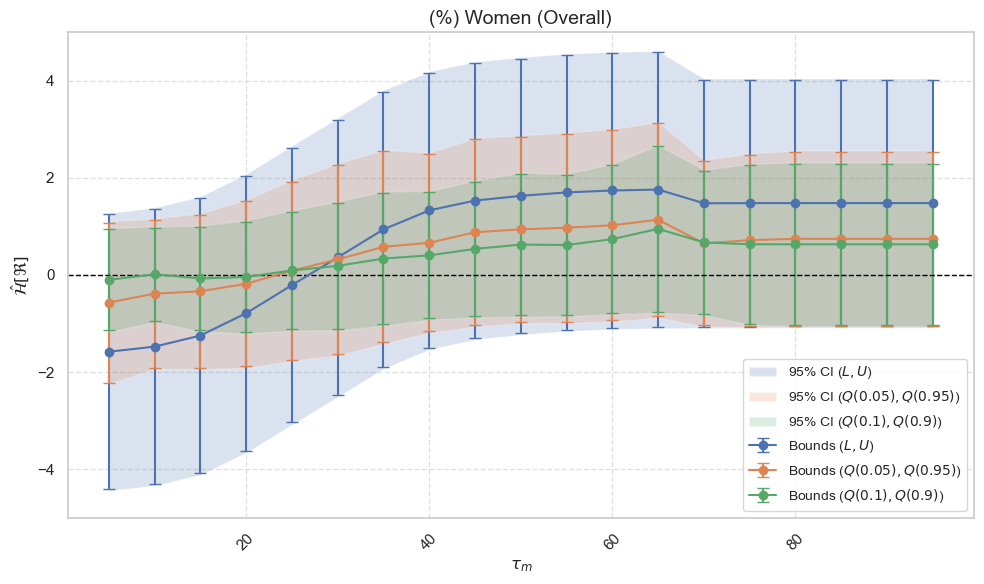

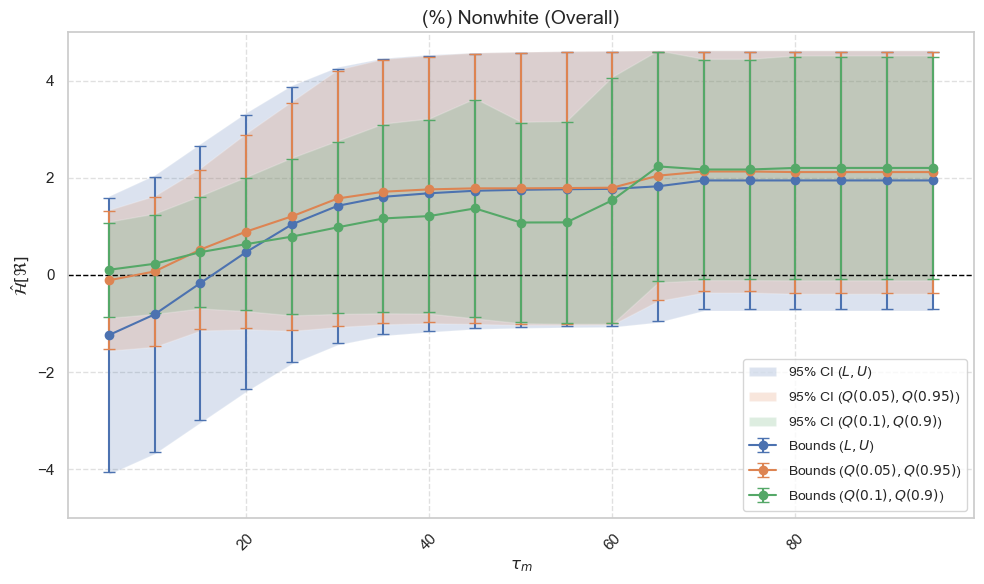

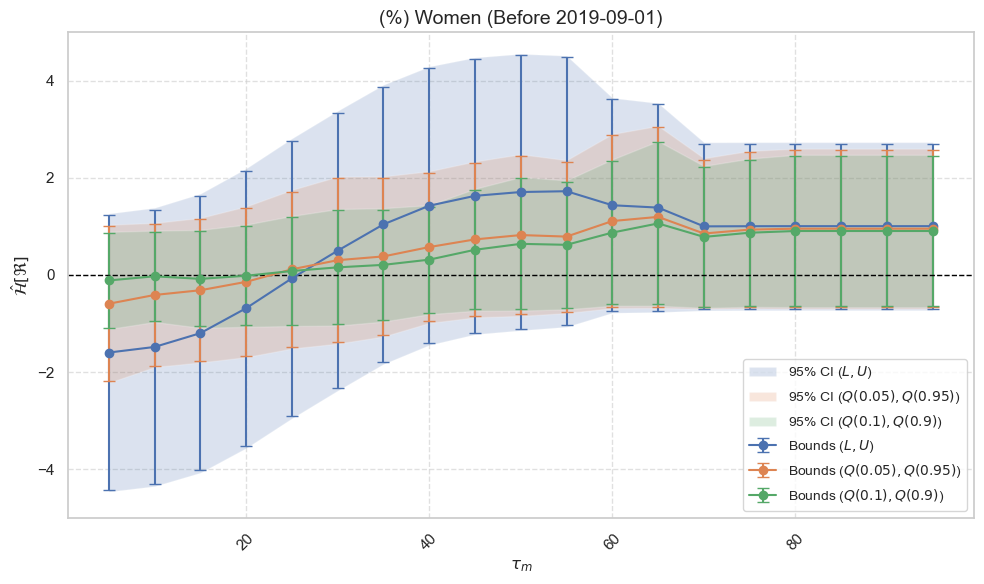

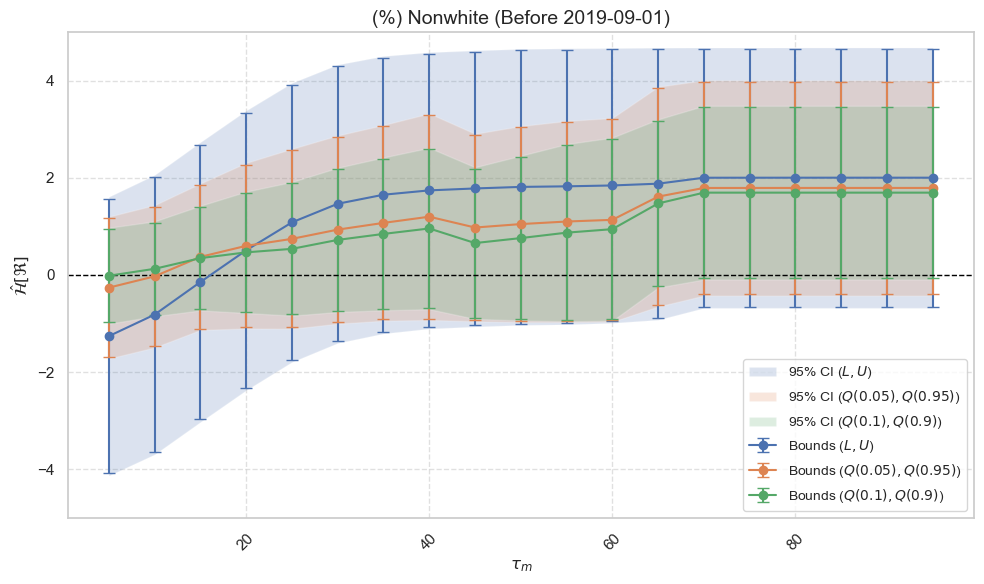

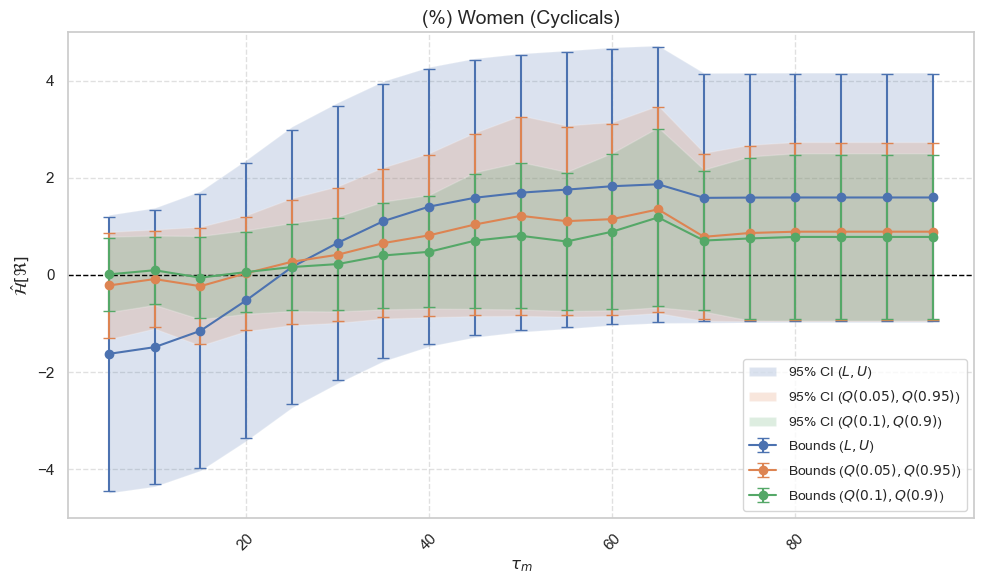

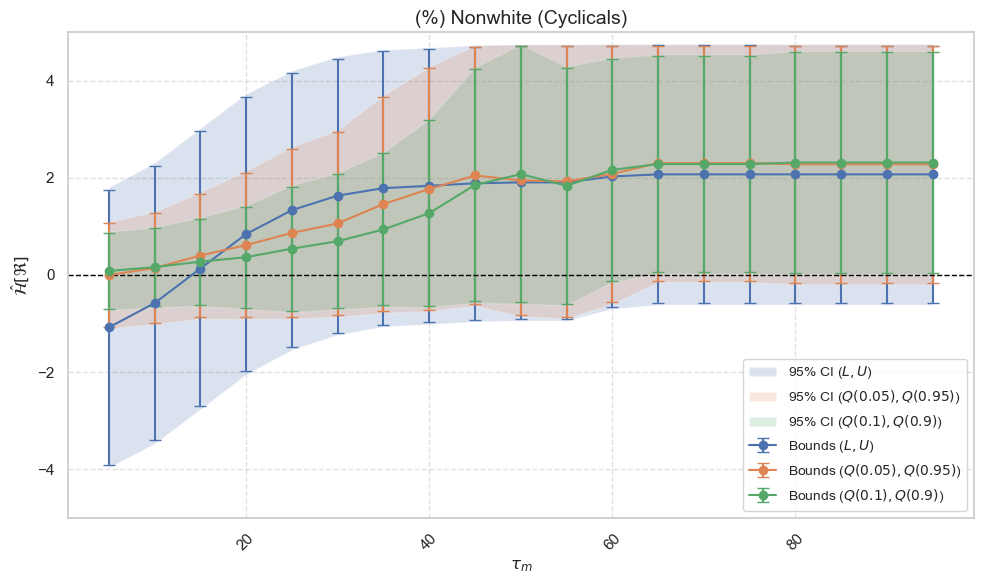

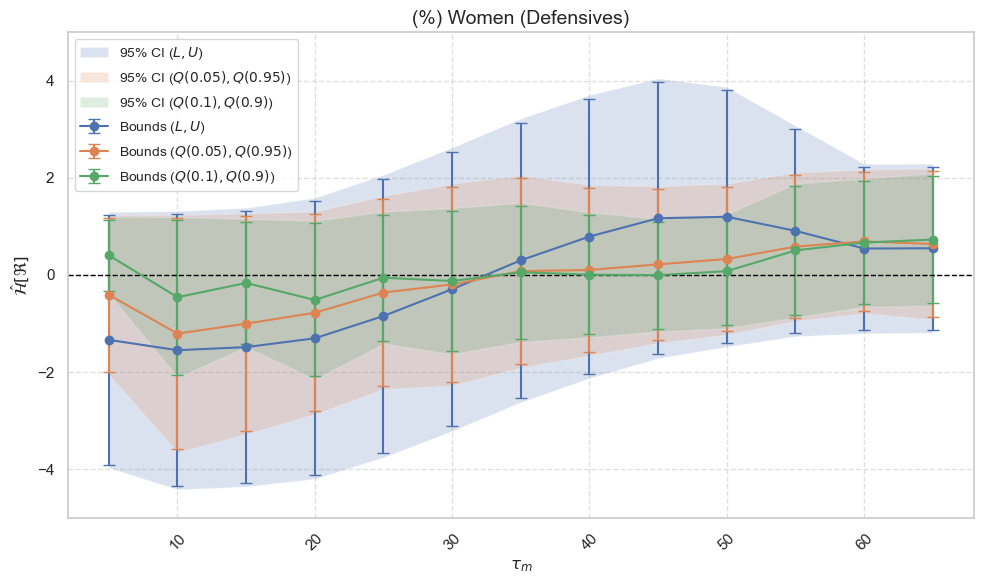

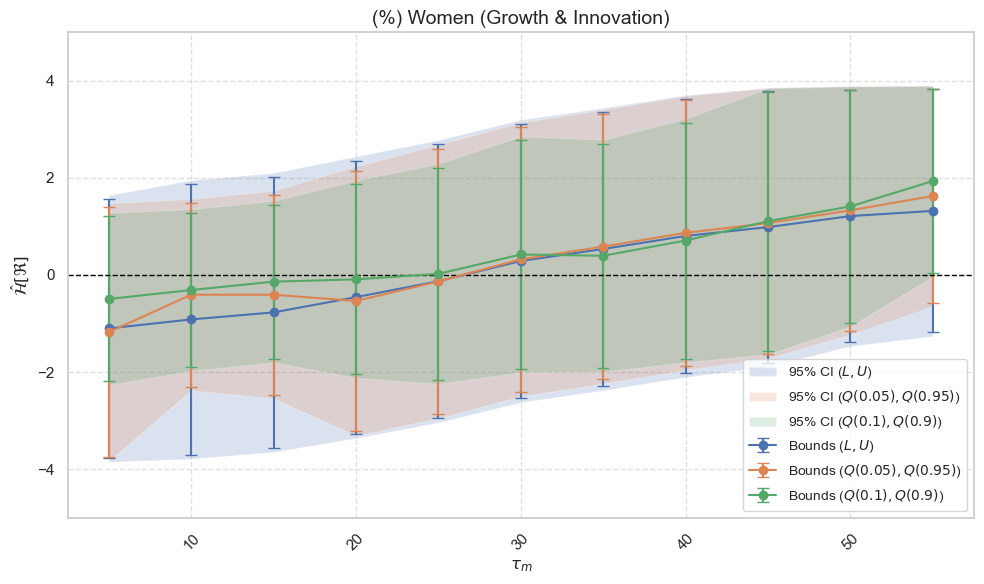

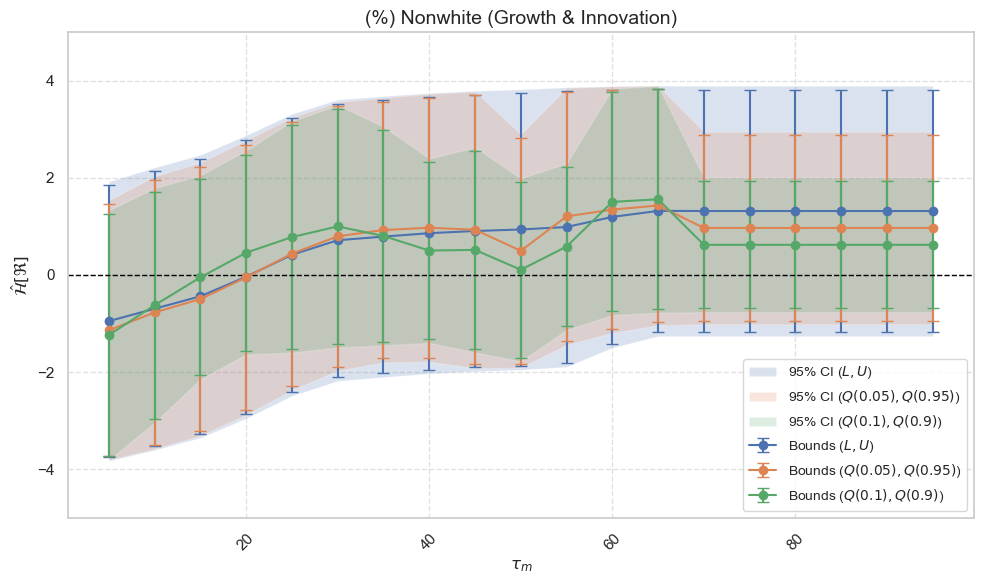

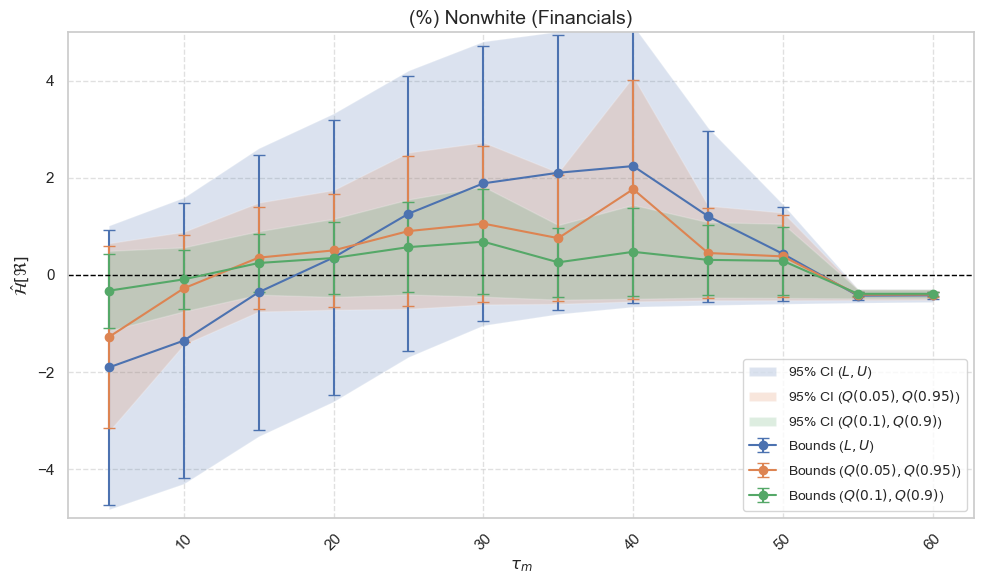

In [54]:
def plot_nonparametric_bounds(nonparametric_bounds, key, signal):
    """
    Superimpose all quantile series for one key + signal,
    converting everything to numeric arrays to avoid TypeErrors.
    """
    fig, ax = plt.subplots(figsize=(10, 6))

    for quantt, df in nonparametric_bounds[key][signal].items():
        # 1) Extract the raw index and convert to float
        #    Assumes df.index are either numbers or strings like '5', '10', etc.
        try:
            x_raw = df.index.astype(float)
        except:
            x_raw = np.array([float(str(idx).lstrip('tau').strip()) 
                              for idx in df.index], dtype=float)

        # 2) Extract bounds and CIs as floats
        lower    = df["Lower"].astype(float).to_numpy()
        upper    = df["Upper"].astype(float).to_numpy()
        ci_low   = df["2.5%"].astype(float).to_numpy()
        ci_high  = df["97.5%"].astype(float).to_numpy()

        # 3) Compute centers and half‐widths
        center = (lower + upper) / 2
        err    = (upper - lower) / 2

        # 4) Mask out any non‐finite entries
        mask = np.isfinite(x_raw) & np.isfinite(center) & np.isfinite(err)
        x  = x_raw[mask]
        yc = center[mask]
        ye = err[mask]
        ylo = ci_low[mask]
        yhi = ci_high[mask]
        
        if quantt == "MiniMax":
            label_legend = r"$L,U$"
        else:
            label_legend = f"$Q({quantt}),Q({1-quantt})$"

        # 5) Plot
        ax.errorbar(
            x, yc, yerr=ye, fmt='o-', capsize=4,
            label=f'Bounds ({label_legend})'
        )

        ax.fill_between(
            x, ylo, yhi, alpha=0.2,
            label=f'95% CI ({label_legend})'
        )

    # Labels & style
    signal_label = (signal
                    .replace("_", " ")
                    .title()
                    .replace("Hq","")
                    .replace("Senior","")
                    .replace("Top","")
                    .replace(" ","")
                    .replace("P", "(%) "))
    key_label = (key
                 .title()
                 .replace("_", " ")
                 .replace("Simple Signal", "Overall")
                 .replace("Filtered Years", "Before 2019-09-01"))

    ax.set_title(f'{signal_label} ({key_label})', fontsize=14)
    ax.set_xlabel(r'$\tau_m$', fontsize=12)
    ax.set_ylabel(r'$\mathcal{\hat{H}}[\Re]$', fontsize=12)
    ax.set_ylim(-5, 5)
    ax.axhline(0, color='black', linestyle='--', linewidth=1)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(loc='best', fontsize='small')

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"Nonparametric_Bounds_{key}_{signal}.png",
                bbox_inches="tight", facecolor="white")
    plt.show()
    plt.close()


# Example loop to generate for all keys/signals
for key, signals in nonparametric_bounds_95.items():
    if "dividend" not in key:
        for signal in signals:
            if "white" not in key:
                plot_nonparametric_bounds(nonparametric_bounds_95, key, signal)


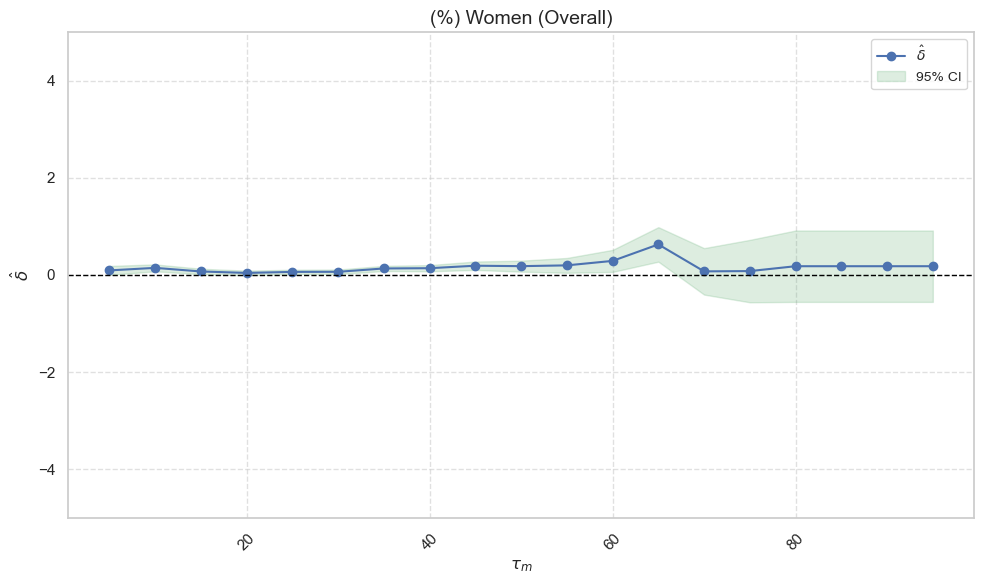

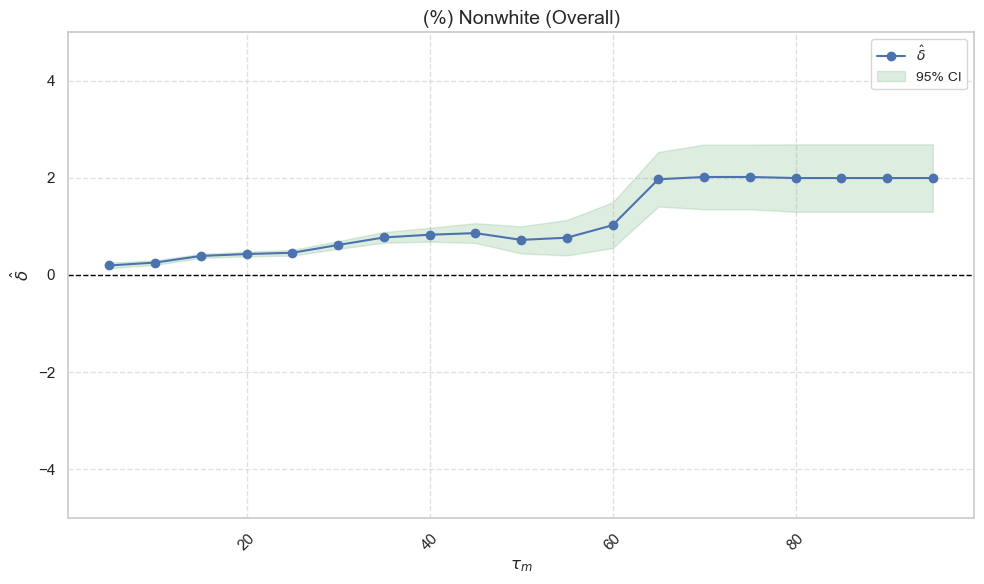

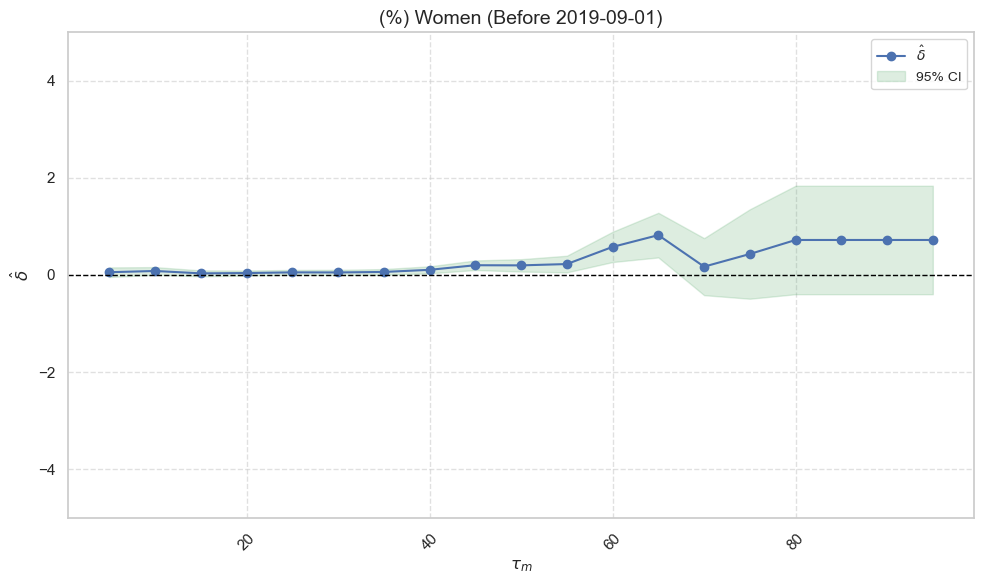

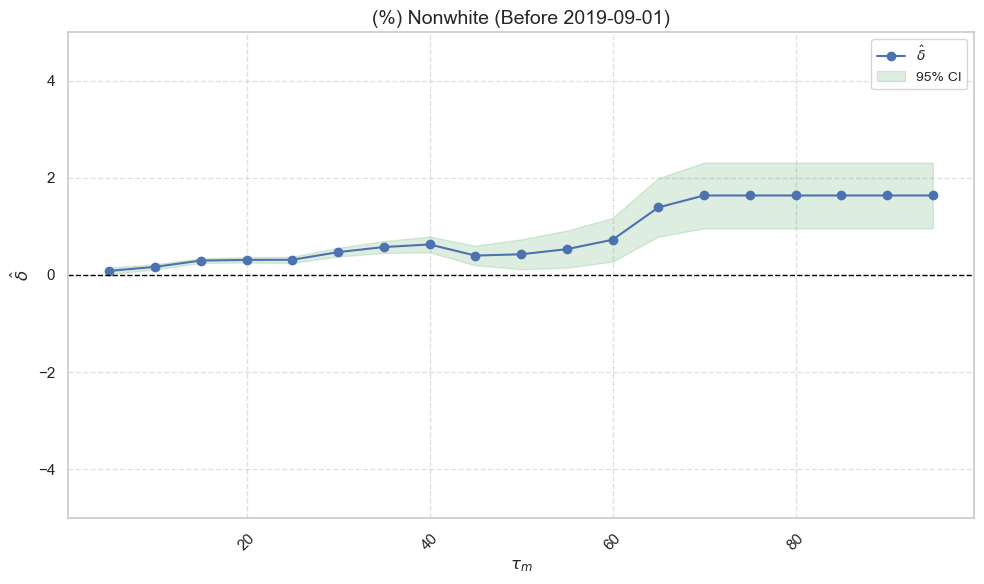

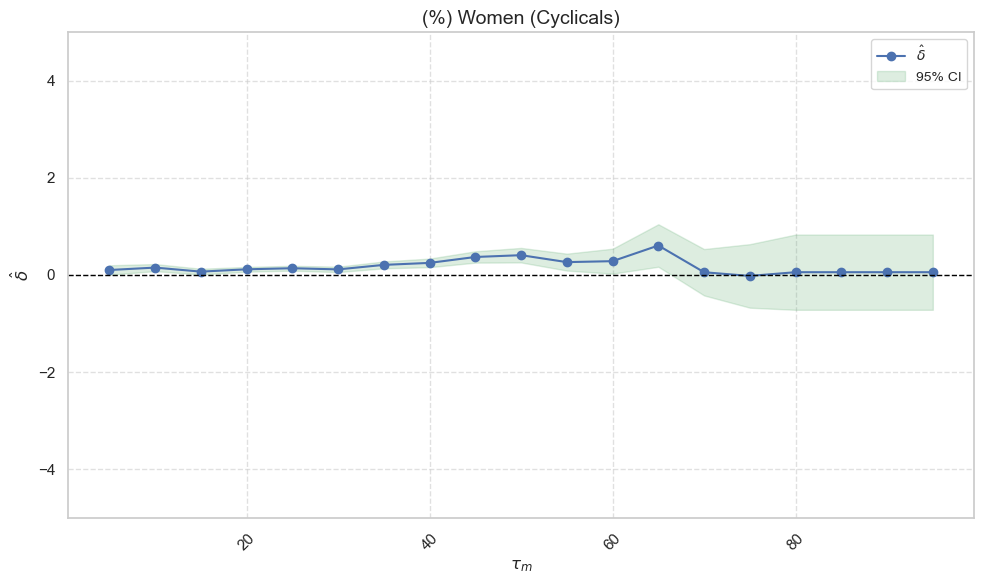

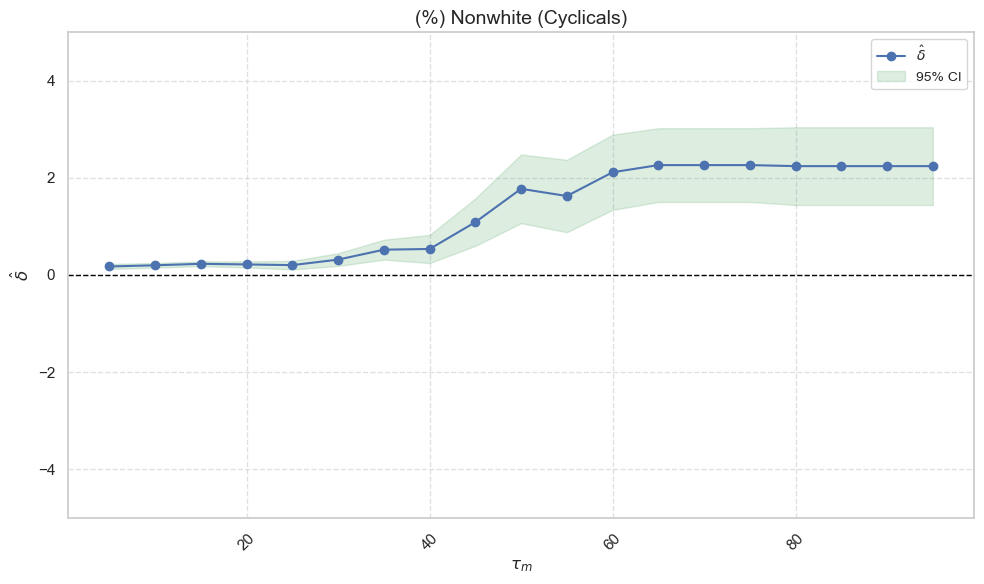

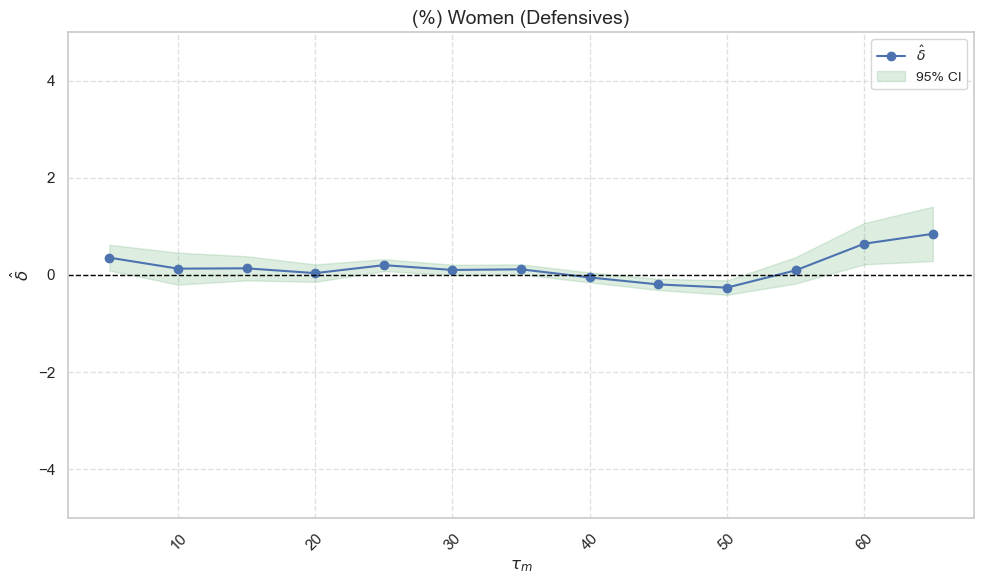

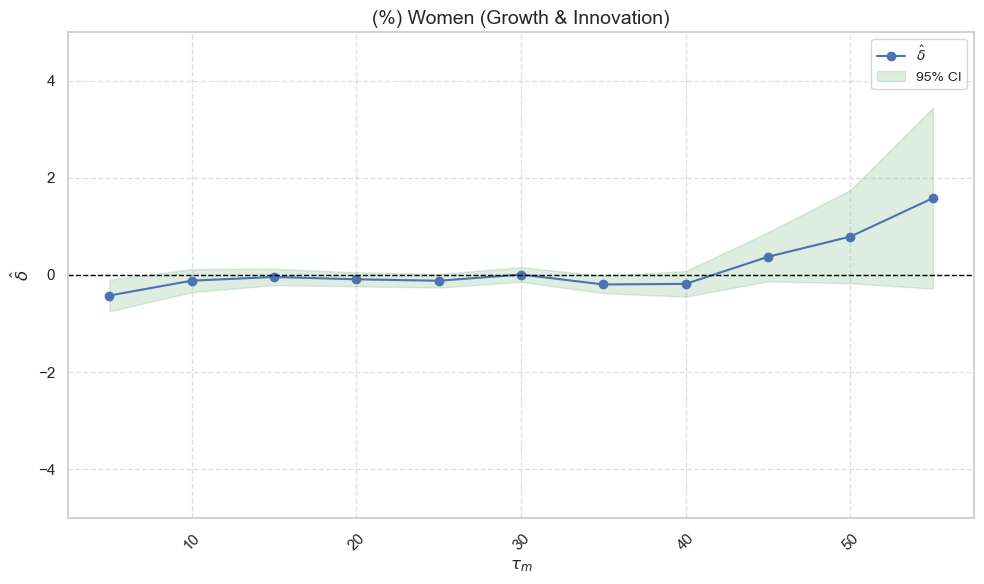

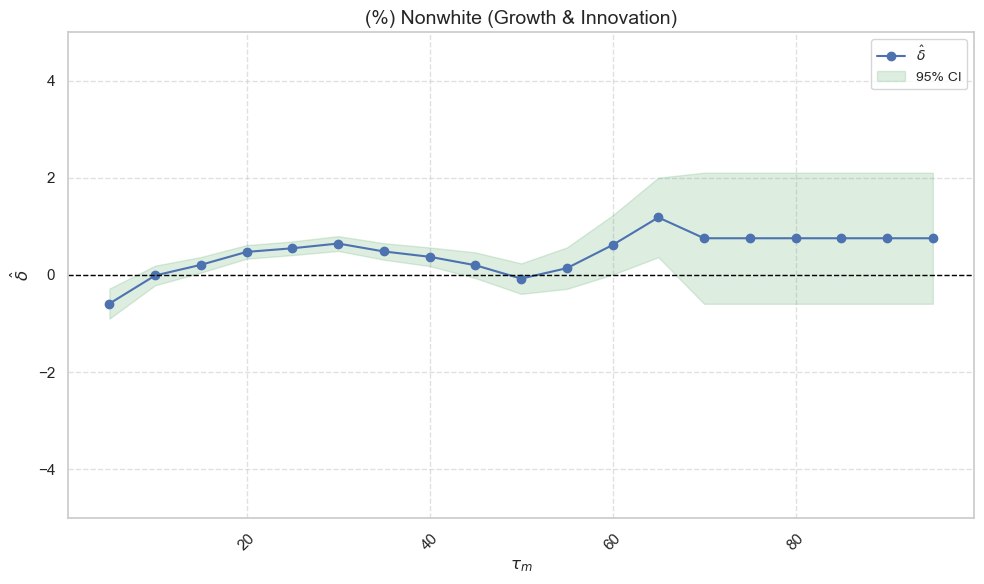

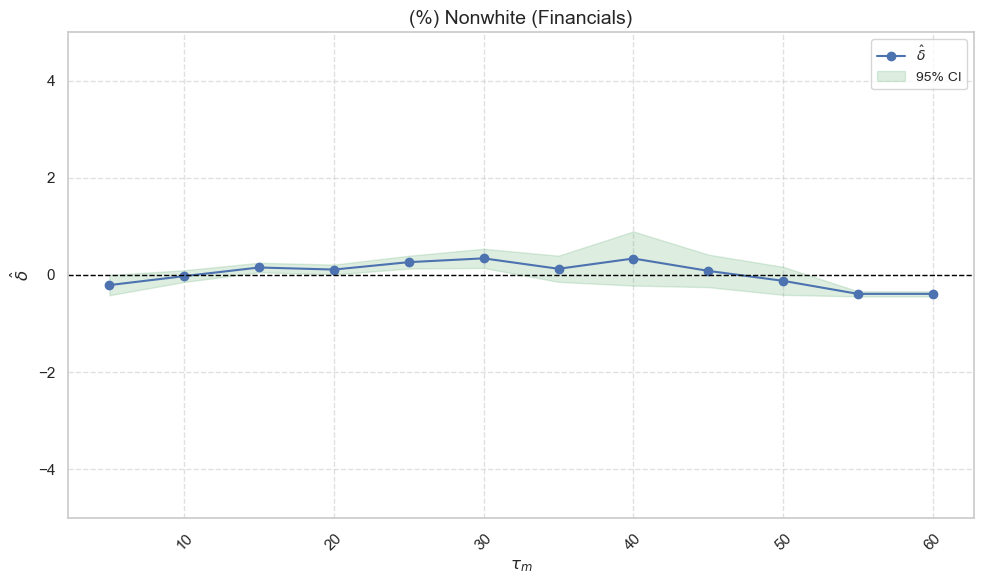

In [57]:
def plot_Angrist(Angrist_bounds, key, signal):
    """
    Plot the point estimate (mean difference) with 95% CI for each tau=k,
    all on one axes.
    """
    # 1) grab the table for this key & signal
    df = Angrist_bounds[key][signal]
    # if your index is like ['tau5','tau10',…] you may want to convert:
    try:
        x = df.index.astype(float)
    except:
        x = np.array([float(str(lbl).lstrip('tau')) for lbl in df.index])

    # 2) pull out the columns
    center = df['mean'].astype(float).to_numpy()
    lo95   = df['lower95'].astype(float).to_numpy()
    hi95   = df['upper95'].astype(float).to_numpy()
    err     = (hi95 - lo95) / 2

    # 3) make the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(
        x, center,
        'o-',
        color='C0',
        label=r'$\hat\delta$'
    )
    # keep the shaded 95% band:
    ax.fill_between(x, lo95, hi95, color='C2', alpha=0.2, label=r'95% CI')

    # 4) labels & styling
    signal_label = (signal
                    .replace("_", " ")
                    .title()
                    .replace("Hq","")
                    .replace("Senior","")
                    .replace("Top","")
                    .replace(" ","")
                    .replace("P", "(%) "))
    key_label = (key
                 .title()
                 .replace("_", " ")
                 .replace("Simple Signal", "Overall")
                 .replace("Filtered Years", "Before 2019-09-01"))
    ax.set_title(f"{signal_label} ({key_label})", fontsize=14)
    ax.set_xlabel(r'$\tau_m$', fontsize=12)
    ax.set_ylabel(r'$\hat{\delta}$', fontsize=12)
    ax.set_ylim(-5, 5)
    ax.axhline(0, color='black', linestyle='--', linewidth=1)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(loc='best', fontsize='small')

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"Angrist_{key}_{signal}.png",
                bbox_inches="tight",
                facecolor="white")
    plt.show()
    plt.close()


# then call:
for key, signals in Angrist.items():
    for signal in signals:
        plot_Angrist(Angrist, key, signal)


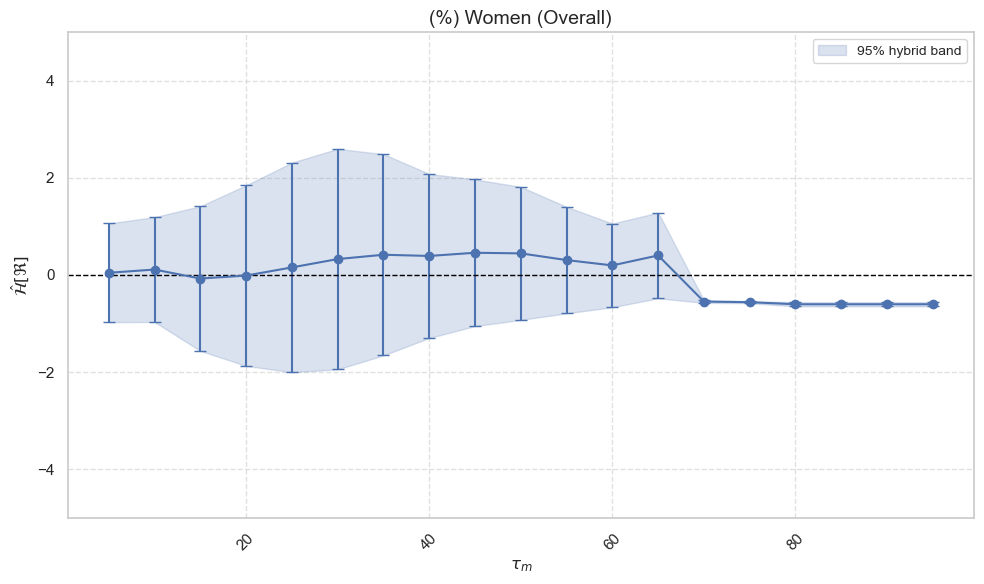

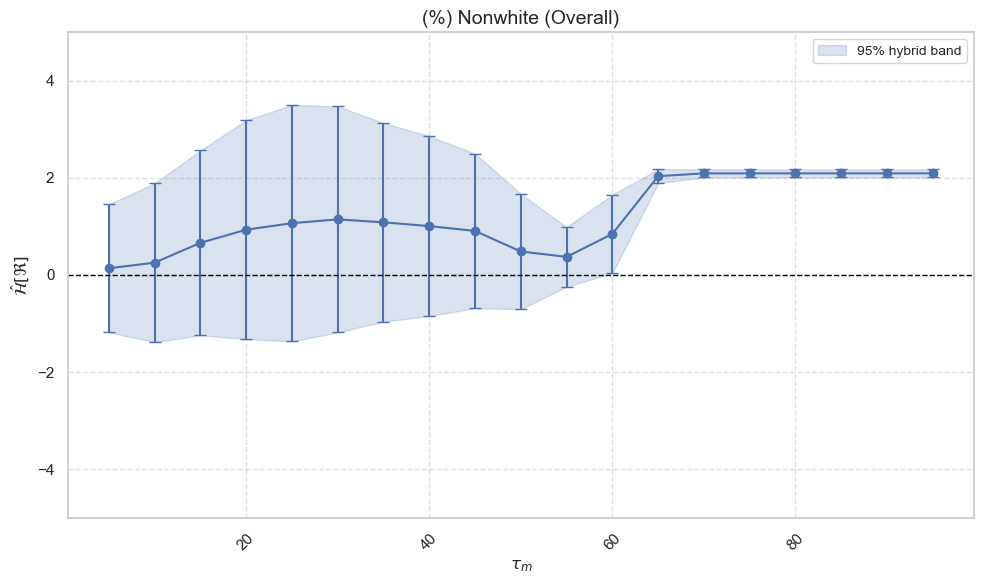

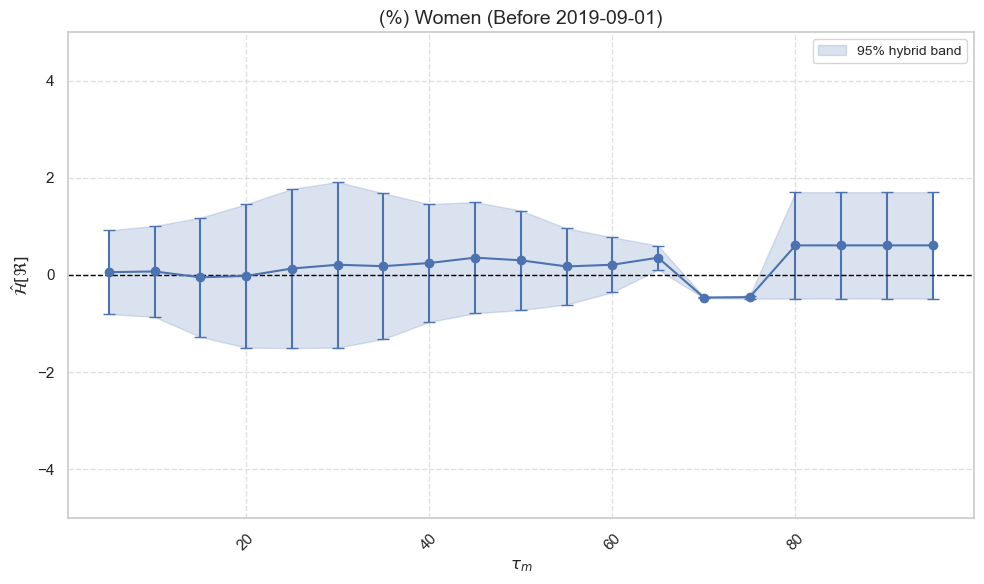

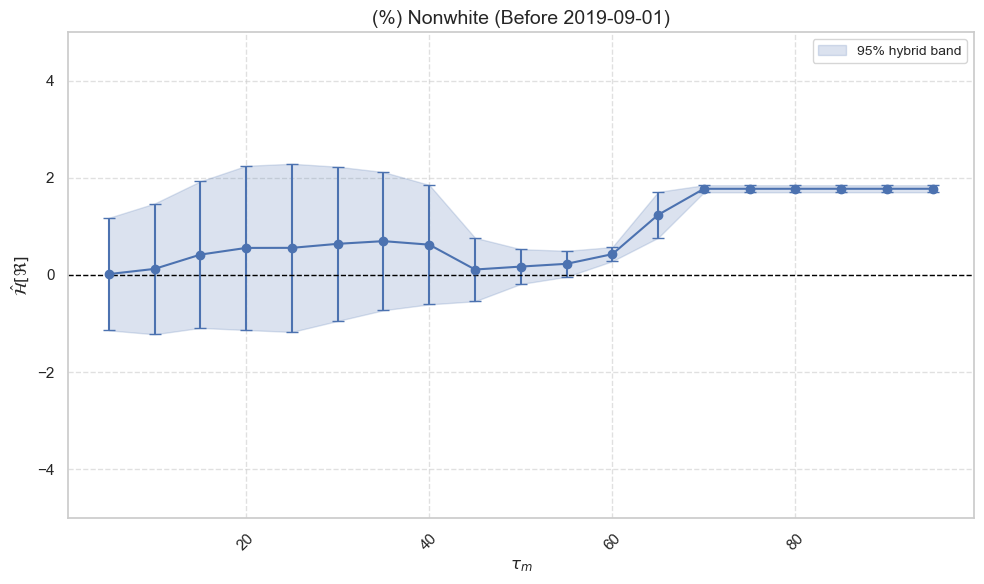

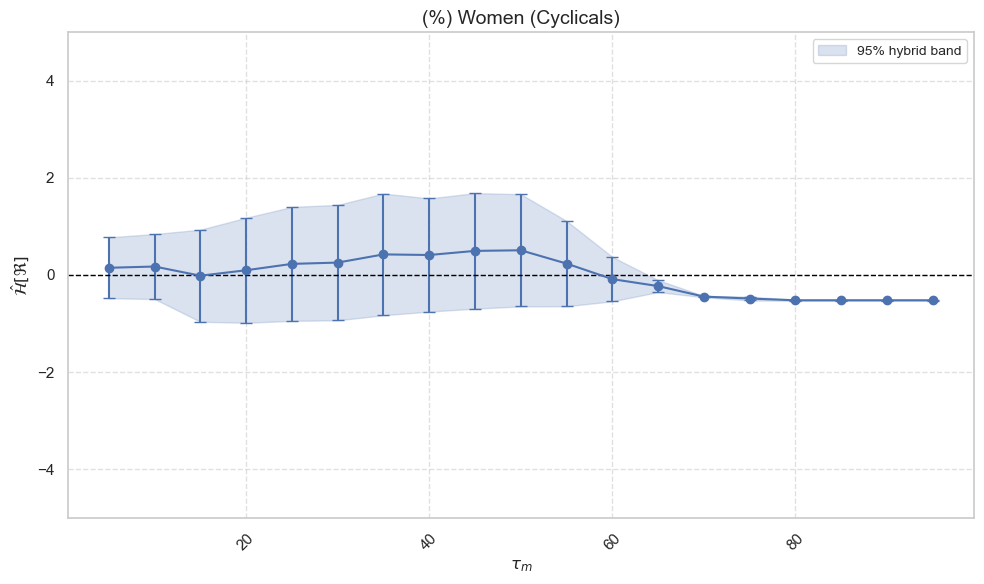

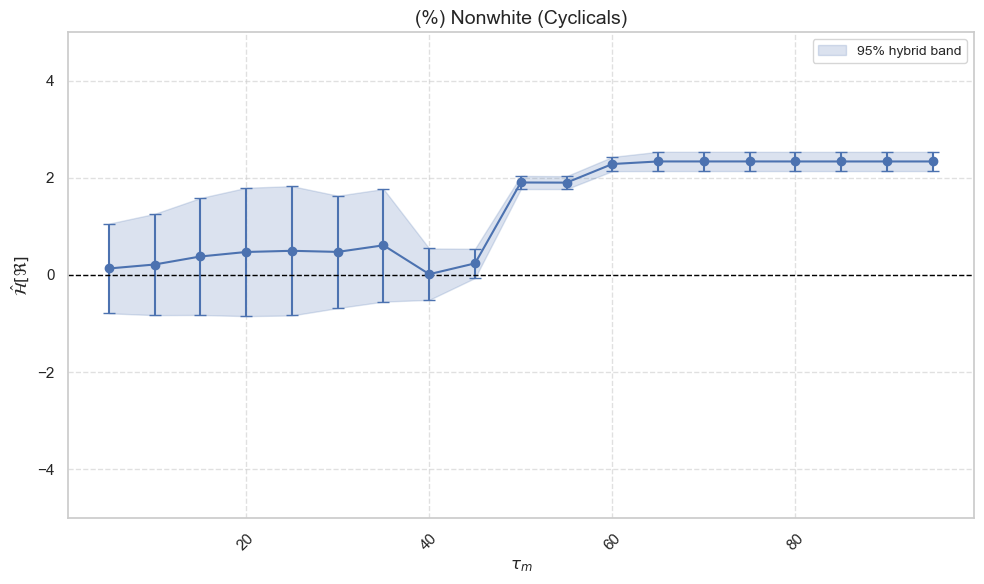

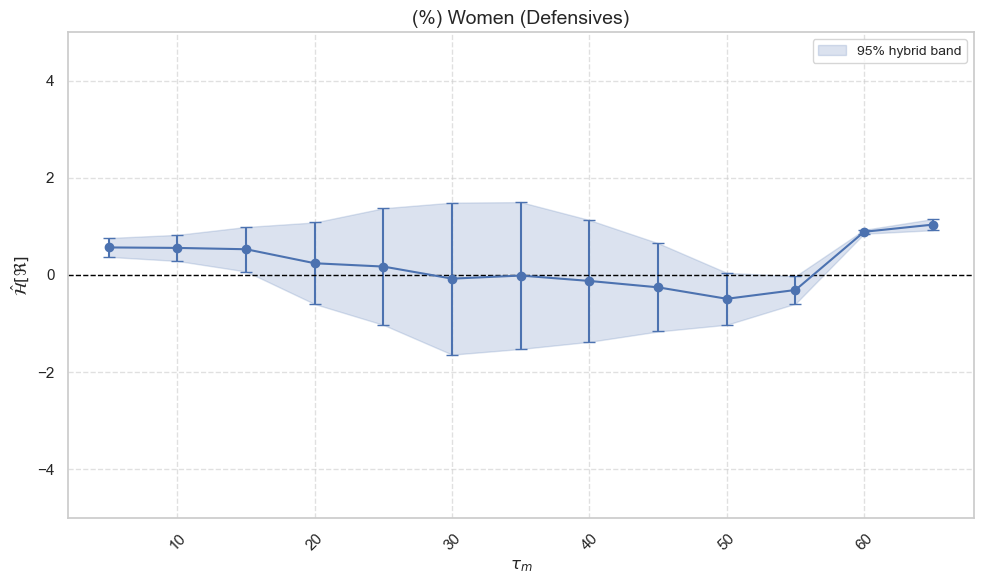

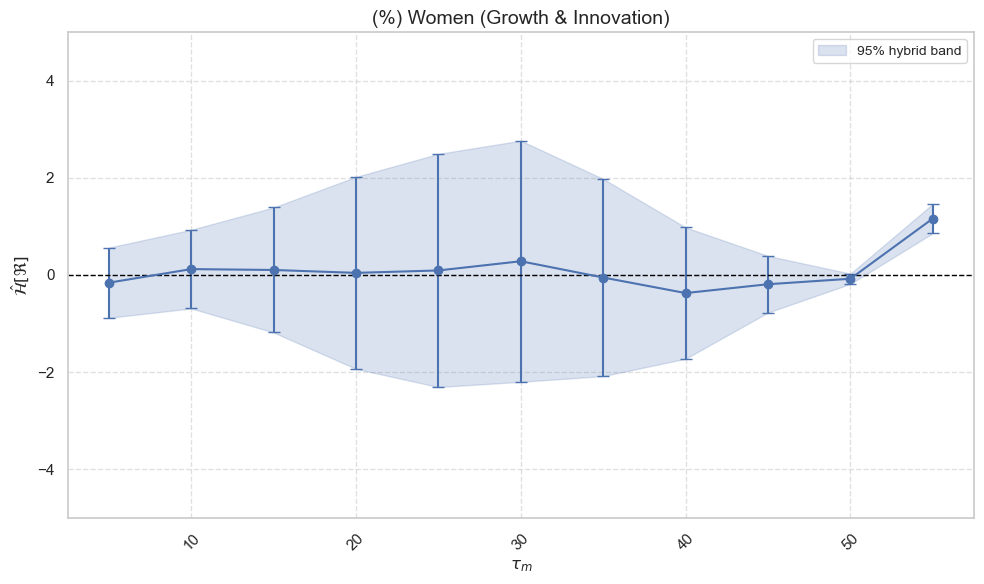

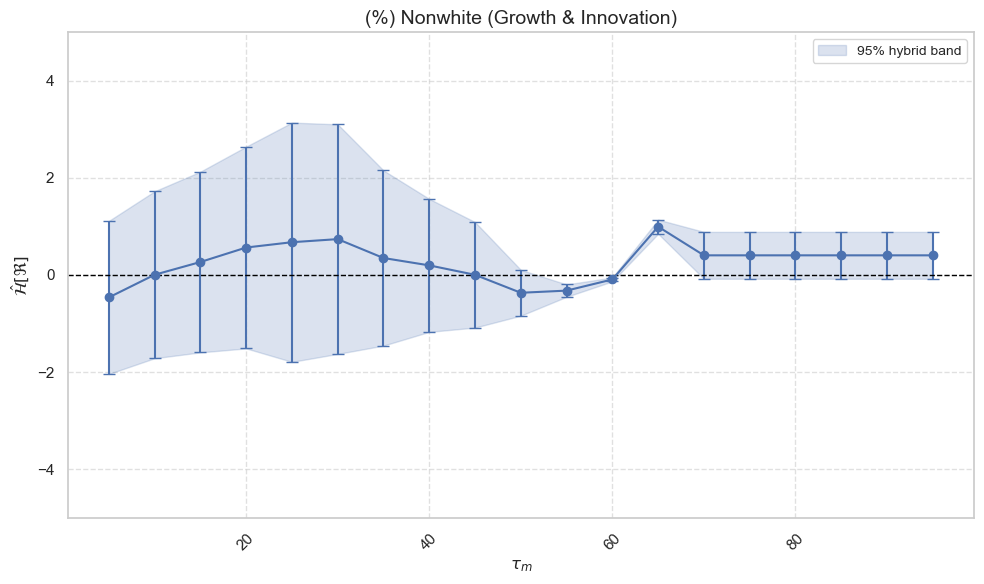

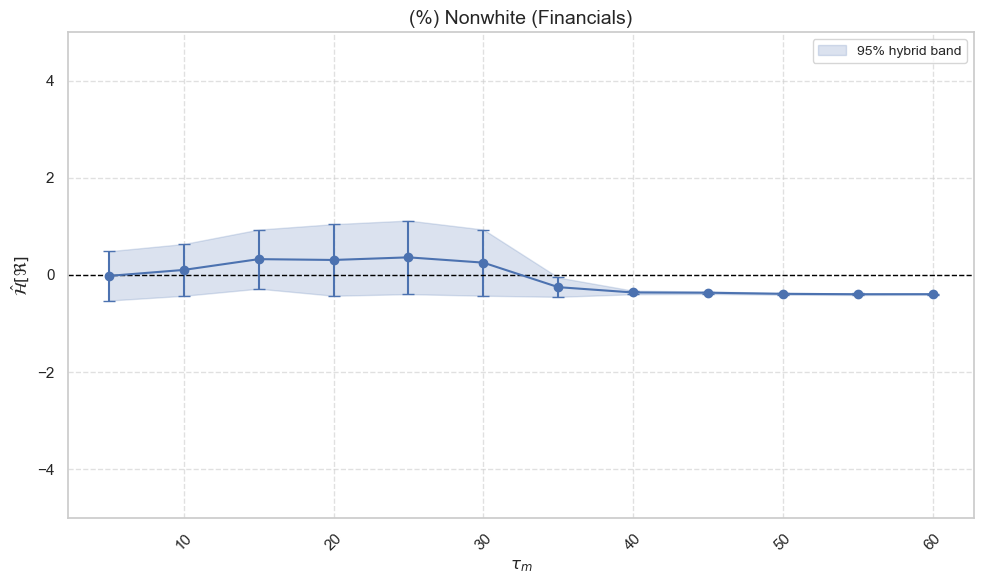

In [56]:
def plot_nonparametric_bounds_hybrid(bounds_hyb, key, signal):
    """
    Same styling as your original routine, but:
    • uses Lower / Upper to draw the coloured band
    • keeps a single colour (matplotlib cycle[0]) exactly like the first trace
    """

    # ------------- grab DataFrame ---------------------------------
    df = bounds_hyb[key][signal]

    # x-axis numeric conversion identical to old code
    try:
        x_raw = df.index.astype(float)
    except Exception:
        x_raw = np.array([float(str(idx).lstrip('tau').strip())
                          for idx in df.index])

    lower = df["Lower"].astype(float).to_numpy()
    upper = df["Upper"].astype(float).to_numpy()
    center = (lower + upper) / 2.0
    err    = (upper - lower) / 2.0

    mask = np.isfinite(x_raw) & np.isfinite(center) & np.isfinite(err)
    x, yc, ye = x_raw[mask], center[mask], err[mask]
    ylo, yhi  = lower[mask], upper[mask]

    # ------------- plot -------------------------------------------
    fig, ax = plt.subplots(figsize=(10, 6))

    # first draw the band: use current colour cycle[0]
    colour = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
    ax.fill_between(x, ylo, yhi, color=colour, alpha=0.20,
                    label='95% hybrid band')

    # now error bars on top in the same colour
    ax.errorbar(x, yc, yerr=ye, fmt='o-', capsize=4,
                color=colour)

    # ------------- cosmetics (unchanged) --------------------------
    signal_label = (signal.replace("_", " ").title()
                             .replace("Hq","")
                             .replace("Senior","")
                             .replace("Top","")
                             .replace(" ","")
                             .replace("P", "(%) "))
    key_label = (key.title()
                     .replace("_", " ")
                     .replace("Simple Signal", "Overall")
                     .replace("Filtered Years", "Before 2019-09-01"))

    ax.set_title(f'{signal_label} ({key_label})', fontsize=14)
    ax.set_xlabel(r'$\tau_m$', fontsize=12)
    ax.set_ylabel(r'$\mathcal{\hat{H}}[\Re]$', fontsize=12)
    ax.set_ylim(-5, 5)
    ax.axhline(0, color='black', linestyle='--', linewidth=1)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(loc='best', fontsize='small')

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'Nonparametric_Bounds_hybrid_{key}_{signal}.png',
                bbox_inches='tight', facecolor='white')
    plt.show()
    plt.close()

for key, signals in nonparametric_bounds_95_hyb.items():
    for signal in signals:
        plot_nonparametric_bounds_hybrid(nonparametric_bounds_95_hyb, key, signal)


In [60]:
# ---------------- 1. list files once ---------------------------------
files = os.listdir('.')

# ---------------- 2. build list of triplets --------------------------
hyb_pat  = re.compile(r'^Nonparametric_Bounds_hybrid_(?P<key>.+)_(?P<sig>.+)\.png$')
mans_pat = re.compile(r'^Nonparametric_Bounds_(?P<key>.+)_(?P<sig>.+)\.png$')
triples = []

for f in files:
    m = hyb_pat.match(f)
    if not m:
        continue
    key, signal = m.group('key'), m.group('sig')
    mans_file   = f"Nonparametric_Bounds_{key}_{signal}.png"
    angr_file   = f"Angrist_{key}_{signal}.png"
    if mans_file in files and angr_file in files:
        triples.append((key, signal, f, mans_file, angr_file))
    else:
        if mans_file not in files:
            print(f"⚠️ Missing Manski PNG for {key}/{signal}")
        if angr_file not in files:
            print(f"⚠️ Missing Angrist PNG for {key}/{signal}")

if not triples:
    raise RuntimeError("No complete Hybrid/Manski/Angrist triplets found.")

# ---------------- 3. helper to clean caption text --------------------
def clean_caption(txt):
    txt = txt.replace("_", " ").lower()
    txt = txt.replace("simple signal", "overall")
    txt = txt.replace("filtered years", "pre 01/04/2019")
    txt = re.sub(r'\bp\b', r'(\%)', txt)
    txt = txt.replace("senior top hq", "")
    txt = txt.replace("&", r"\&")
    return txt.strip().capitalize()

# ---------------- 4. emit LaTeX 3×N figures --------------------------
chunk_size = 2          # → 2×3 = 6 subfigures per page (tweak as you like)

for i in range(0, len(triples), chunk_size):
    chunk = triples[i:i+chunk_size]
    print(r"\begin{figure}[H]")
    print("  \\centering")
    for j, (key, signal, hyb_png, mans_png, ang_png) in enumerate(chunk):

        base = clean_caption(f"{key} {signal}")

        # escape & in file names
        hyb_png  = hyb_png.replace("&", r"\&")
        mans_png = mans_png.replace("&", r"\&")
        ang_png  = ang_png.replace("&", r"\&")

        #  --- Hybrid ---------------------------------
        print(f"""  \\begin{{subfigure}}[b]{{0.30\\textwidth}}
    \\includegraphics[width=\\linewidth]{{{hyb_png}}}
    \\caption{{Hybrid: {base}}}
  \\end{{subfigure}}""")
        print("  \\hfill")

        #  --- Manski / nonparametric -----------------
        print(f"""  \\begin{{subfigure}}[b]{{0.30\\textwidth}}
    \\includegraphics[width=\\linewidth]{{{mans_png}}}
    \\caption{{Nonparametric: {base}}}
  \\end{{subfigure}}""")
        print("  \\hfill")

        #  --- Angrist --------------------------------
        print(f"""  \\begin{{subfigure}}[b]{{0.30\\textwidth}}
    \\includegraphics[width=\\linewidth]{{{ang_png}}}
    \\caption{{Angrist: {base}}}
  \\end{{subfigure}}""")

        # row spacing within the same figure
        if j < chunk_size - 1:
            print("  \\par\\medskip")

    print("  \\caption{Hybrid, Manski nonparametric and Angrist estimates}")
    print(r"\end{figure}")
    print()


\begin{figure}[H]
  \centering
  \begin{subfigure}[b]{0.30\textwidth}
    \includegraphics[width=\linewidth]{Nonparametric_Bounds_hybrid_Cyclicals_p_nonwhite_senior_top_hq.png}
    \caption{Hybrid: Cyclicals (\%) nonwhite}
  \end{subfigure}
  \hfill
  \begin{subfigure}[b]{0.30\textwidth}
    \includegraphics[width=\linewidth]{Nonparametric_Bounds_Cyclicals_p_nonwhite_senior_top_hq.png}
    \caption{Nonparametric: Cyclicals (\%) nonwhite}
  \end{subfigure}
  \hfill
  \begin{subfigure}[b]{0.30\textwidth}
    \includegraphics[width=\linewidth]{Angrist_Cyclicals_p_nonwhite_senior_top_hq.png}
    \caption{Angrist: Cyclicals (\%) nonwhite}
  \end{subfigure}
  \par\medskip
  \begin{subfigure}[b]{0.30\textwidth}
    \includegraphics[width=\linewidth]{Nonparametric_Bounds_hybrid_Cyclicals_p_women_senior_top_hq.png}
    \caption{Hybrid: Cyclicals (\%) women}
  \end{subfigure}
  \hfill
  \begin{subfigure}[b]{0.30\textwidth}
    \includegraphics[width=\linewidth]{Nonparametric_Bounds_Cyclicals_p_w